# Chapter 3: Tuned gain control model

Last access (y.m.d): 23.01.31   
Last update (y.m.d): 23.01.31

Note that the original notebook started for this chapter (analysis_ch3) is still there and serves as a supplemental/more stream of consciousness space for this work.

# Contents
1. Model construction
2. Modle analysis: Cross-validation  


In [44]:
import pandas as pd
pd.set_option('display.float_format', '{:.3f}'.format)

import pdb
import model_responses_pytorch as mrpt
import plot_superposition_func as psf
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

import warnings
warnings.filterwarnings(action='once')

import numpy as np
import os
import helper_fcns as hf
import helper_fcns_sfBB as hf_sfBB
# import model_responses as mr
import scipy.stats as ss
import scipy.odr.odrpack as odrpack
from scipy.stats.mstats import gmean
from scipy.stats import ks_2samp, kstest, linregress
import itertools
import autoreload
from IPython.core.display import display, HTML, Image

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.backends.backend_pdf as pltSave
from matplotlib.ticker import FuncFormatter

from helper_fcns_sfBB import compute_f1f0 as bb_compute_f1f0
from helper_fcns_sfBB import get_resp_str

import plot_sf_figs as psf

# plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

base_dir = os.getcwd() + '/';

%matplotlib inline

In [46]:
from matplotlib import rcParams

tex_width = 469; # per \layout in Overleaf on document
sns_offset = 2; 
hist_width = 0.9;
hist_ytitle = 0.94; # moves the overall title a bit further down on histogram plots

rcParams.update(mpl.rcParamsDefault)

fontsz = 12;
tick_scalar = 1.5;

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

usetex = False

rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {'text.usetex' : usetex,
          'font.size' : fontsz,
          'font.family': 'lmodern',
           'font.style': 'italic'}
plt.rcParams.update(params)

# rcParams['lines.linewidth'] = 2.5;
rcParams['lines.markeredgewidth'] = 0; # no edge, since weird tings happen then
# rcParams['axes.linewidth'] = 2; # was 1.5
# rcParams['lines.markersize'] = 5;

tick_adj = ['xtick.major.size', 'xtick.minor.size', 'ytick.major.size', 'ytick.minor.size']
for adj in tick_adj:
    rcParams[adj] = rcParams[adj] * tick_scalar;
    
%matplotlib inline

date = '_230129'

saveName = 'figures/reports/ch03_fullModel%s/' % (date); # for one save name for all figures
save_loc = base_dir + saveName;

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.


In [47]:
autoreload.reload(hf);

# 0. Setting up
e.g. colors

In [48]:
# Load jointLists
lgn = hf.np_smart_load('jointList_LGN_230121_vT00_dvT00_jt7.npy')
v1 = hf.np_smart_load('jointList_wMods_V1_230121vE_vT00_dvT00_m3j10.npy')

#### NOTE: THE BELOW IS JUST A PRELIMINARY GO AT THINGS SO THAT WE CAN GET COLORS

whichExps = ['lgn', 'v1'];

df = None;
area_all = [];
type_all = [];
# vThresh = 10 #-np.Inf
vThresh = 0 #-np.Inf

for which_exp in whichExps:

    which_jl = lgn if which_exp=='lgn' else v1;

    area = [which_exp] * len(which_jl);
    ####
    # tuning, basic metrics
    # --- note: [0] following jl_get_metric_byCon is to get only the first output (i.e. ignore the con. vals)
    ####
    respMeasure = hf.jl_get_metric_byCon(which_jl, ['respMeasure'], conVal=None, disp=None, fieldOverwrite='metadata')[0]
    if which_exp == 'lgn':
        cellType = np.array([which_jl[x]['metadata']['cellType'] for x in which_jl.keys()])
        non_mp = np.logical_and(~(cellType=='parvo'), ~(cellType=='magno'))
        cellType[non_mp] = 'other'
    elif which_exp == 'v1':
        cellType = respMeasure.astype('bool'); # i.e. cellType becomes 'is it simple?'

    cellNum = hf.jl_get_metric_byCon(which_jl, ['cellNum'], conVal=None, disp=None, fieldOverwrite='metadata')[0].astype('int')
    slps = -hf.jl_get_metric_byCon(which_jl, 'dog_mod_slope', conVal=None, disp=0)[0]
    bw34_split = hf.jl_get_metric_byCon(which_jl, 'dog_bw34_split', conVal=1, disp=0)[0][:, 1]
    bw34 = hf.jl_get_metric_byCon(which_jl, 'dog_bw34', conVal=1, disp=0)[0]
    bwHalf_split = hf.jl_get_metric_byCon(which_jl, 'dog_bwHalf_split', conVal=1, disp=0)[0][:, 1]
    bwHalf = hf.jl_get_metric_byCon(which_jl, 'dog_bwHalf', conVal=1, disp=0)[0]
    suprInd_model = hf.jl_get_metric_byCon(which_jl, ['rfsize', 'suprInd_model'], conVal=None, disp=None, fieldOverwrite='basics')[0]
    rfsize = hf.jl_get_metric_byCon(which_jl, ['rfsize', 'gsf_model'], conVal=None, disp=None, fieldOverwrite='basics')[0]
    rfsize_surr = hf.jl_get_metric_byCon(which_jl, ['rfsize', 'surrDiam_model'], conVal=None, disp=None, fieldOverwrite='basics')[0]
    oriBW = hf.jl_get_metric_byCon(which_jl, ['ori', 'bw'], conVal=None, disp=None, fieldOverwrite='basics')[0]
    # other metrics...
    hiCon_varExpl = hf.jl_get_metric_byCon(which_jl, 'dog_varExpl', conVal=1, disp=0)[0] # highest con.
    charFreq = hf.jl_get_metric_byCon(which_jl, 'dog_charFreq', conVal=1, disp=0)[0] # highest con.
    # --- all boot values are NaN for now...would need to re-run
#     charFreq_std = hf.jl_get_metric_byCon(which_jl, 'boot_dog_charFreq_values', conVal=1, disp=0)[0] # highest con.
    f1f0_ratio = hf.jl_get_metric_byCon(which_jl, 'f1f0_ratio', conVal=None, disp=None)[0]
    mn_med_max = hf.jl_get_metric_byCon(which_jl, 'mn_med_max', conVal=None, disp=None)[0]
    mn, md, mx = np.transpose(mn_med_max);
    # c50 stuff (from superposition)
    c50_pref = hf.jl_get_metric_byCon(which_jl, ['disp0_c50'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    c50_pref_emp = hf.jl_get_metric_byCon(which_jl, ['disp0_c50_emp'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    ####
    # mixture metrics
    ####
    sfErrs = hf.jl_get_metric_byCon(which_jl, ['sfErrsInd_wtdVar_prince'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    sfErrs_boot = hf.jl_get_metric_byCon(which_jl, ['sfErrsInd_wtdVar_prince_boot'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    sfErrs_boot_std = np.nanstd(sfErrs_boot, axis=1)
    sfErrs_boot_mdn = np.nanmedian(sfErrs_boot, axis=1)
    super_varExpl = hf.jl_get_metric_byCon(which_jl, ['var_expl'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    super_varExpl_boot = hf.jl_get_metric_byCon(which_jl, ['var_expl_boot'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    super_varExpl_std = np.nanstd(super_varExpl_boot, axis=1)
    super_varExpl_std_clip = np.nanstd(np.clip(super_varExpl_boot, -50, None), axis=1)
    c50_summ = hf.jl_get_metric_byCon(which_jl, ['rel_c50'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    c50_summ_emp = hf.jl_get_metric_byCon(which_jl, ['rel_c50_emp'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    c50_summ_emp_boot = hf.jl_get_metric_byCon(which_jl, ['rel_c50_emp_boot'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    auc = hf.jl_get_metric_byCon(which_jl, ['supr_area'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
    auc_boot_std = np.nanstd(hf.jl_get_metric_byCon(which_jl, ['supr_area_boot'], conVal=None, disp=None, fieldOverwrite='superpos')[0], axis=1)

    curr_df = pd.DataFrame(data=np.transpose([respMeasure, cellNum, f1f0_ratio, hiCon_varExpl, charFreq, 
                                              slps, bwHalf_split, bwHalf, bw34_split, bw34, rfsize, rfsize_surr, 
                                              suprInd_model, oriBW, mn, md, mx, c50_pref, c50_pref_emp, 
                                              sfErrs, sfErrs_boot_std, sfErrs_boot_mdn, 
                                              super_varExpl, super_varExpl_std, super_varExpl_std_clip,
                                              auc, auc_boot_std,
                                              c50_summ, c50_summ_emp]), 
                           columns=['isSimple', 'cellNum', 'f1f0', 'sfVarExpl', 'charFreq',  
                                    'slope', 'bwHalf_split', 'bwHalf', 'bw34_split', 'bw34', 'rfsize', 'rfsize_surr', 
                                    'suprInd', 'oriBW', 'meanResp', 'mdnResp', 'maxResp', 'c50_pref', 'c50_pref_emp', 
                                    'sfErrs', 'sfErrsBootStd', 'sfErrsBootMdn', 
                                    'super_varExpl', 'super_varExpl_std', 'svesc', 
                                    'auc', 'auc_std',
                                    'c50_summ', 'c50_summ_emp'],)
    area_all.append(area);
    type_all.append(cellType);
    if df is None:
        df = curr_df;
    else:
        df = df.append(curr_df)
    
# adding string fields after to avoid other fields being bad...
df.insert(0, 'area', hf.flatten_list(area_all))
df.insert(1, 'cellType', hf.flatten_list(type_all))
df['cellNum'] = df['cellNum'].astype('int')


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [134]:
# get color scheme
area_colors = [];
toGroups = ['cellType', 'cellType']; # corresponding to LGN, V1

pds_split = [df[df['area']=='lgn'], df[df['area']=='v1']]

for mega, whichArea, toGroup in zip(pds_split, whichExps, toGroups):

    cnt = 0;
    grp_names = [];
    for nm, group in mega.groupby(toGroup, sort=False):
        cnt += 1;
        grp_names.append(nm)

    # colors = cm.viridis(np.linspace(0.15, 0.95, cnt))
    if whichArea=='v1':
#         colors = sns.color_palette('husl', n_colors=cnt-1)
        colors = sns.color_palette('viridis', n_colors=cnt-1)
        colors.append((0,0,0)); # add black!
    else: # lgn...
        # why adding extra colors?
        # well, the 3rd color looks like the first in viridis
        colors = sns.color_palette('colorblind', n_colors=cnt+2)
        # so we'll add extras and swap with the desirable one
        colors[2] = colors[4]
        # ignore 'other' color for this chap
        colors = sns.color_palette(colors[0:2])
        
    area_colors.append(colors)
    
lgn_colors, v1_colors = area_colors

# 1. Model construction
What do the different model components look like?
Here, let's make plots of the LGN front-end, normalization pool, for example.

In [135]:
# Since we'll need to plot some model components, just pick model parameters we can draw from!
mod_base = 'fitListHPC_pyt_nr230118a_noRE_noSched' # also assuming that we no free respExp

# NOTE: V1_BB allows for smoother plotting of norm curves!

# we'll make a dictionary of fit lists, where the key is (lgnType, fitType)
# -- as of 23.01.29, we'll assume that all mods with normWt are dgNormFunc
expDir = 'V1_BB/'
# expDir = 'altExp/'
lgnTypes = [0, 4]; # off and shift
fitTypes = [1, 2, 7]; # flat, weight, and wghtMatch

ref_isBB = 'BB' in expDir

# --- fixed/unlikely to change
dgNormFunc = 1; # yes, use deriv. Gauss for norm weighting
excType = 1;
lossType = 1;
lgnConType = 1;
vecCorrected = 0;
isCV = False;
lgnForNorm = 1;

all_fits = dict();

for lT,fT in itertools.product(lgnTypes,fitTypes):
    aha = hf.fitList_name(mod_base, fitType=fT, lossType=lossType, lgnType=lT, lgnConType=lgnConType,
                         vecCorrected=vecCorrected, CV=isCV, excType=excType, lgnForNorm=lgnForNorm, dgNormFunc=dgNormFunc)
    curr_fits = hf.np_smart_load('%sstructures/%s' % (expDir, aha))

    all_fits[(lT, fT)] = curr_fits
    
    
### and also get our reference cell
### Load data (to use for vExp calc.)
ref_cellNum = 13 if ref_isBB else 4; # whenever we need an arbitrary cell, use this one
data_loc = base_dir + '%sstructures/' % expDir
expName = hf.get_datalist(expDir, force_full=True);
dataList = hf.np_smart_load(str(data_loc + expName))
expInd   = hf.exp_name_to_ind(dataList['expType'][ref_cellNum-1]);

expData = hf.np_smart_load(data_loc + '%s_%s.npy' % (dataList['unitName'][ref_cellNum-1], 'sfBB' if ref_isBB else 'sfm'))
trialInf = expData['sfBB_core'] if ref_isBB else expData['sfm']['exp']['trial']

# dw_dc = mrpt.dataWrapper(trialInf, respMeasure=0, expInd=expInd)
# dw_f1 = mrpt.dataWrapper(trialInf, respMeasure=1, expInd=expInd)


#### First, what about the normalization pool?

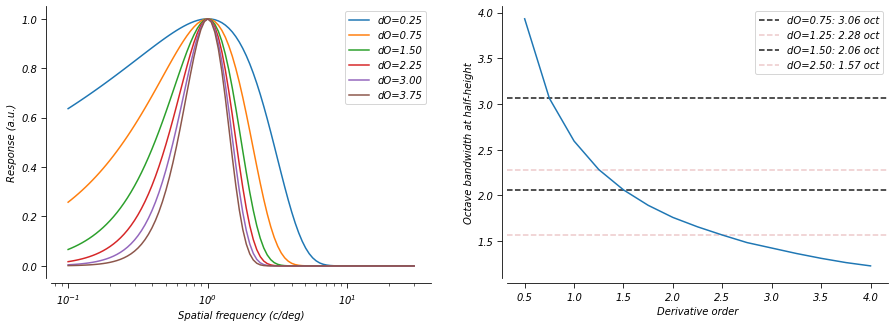

In [136]:
saveName = '01_00_dG_bandwidth.pdf'

stimSf = np.geomspace(0.1, 30, 100);

prefSf = 1;
dOrd = np.arange(0.25, 4.25, 0.25);

f, ax = plt.subplots(1, 2, figsize=(15,5));

all_bws = []; # in octaves at half-height

for i, dOrd_curr in enumerate(dOrd):

    curr_fit = hf.deriv_gauss([prefSf, dOrd_curr], stimSf = stimSf)[0];
    if np.mod(i,3)==2 or i==0:
        ax[0].semilogx(stimSf, curr_fit, label='dO=%.2f' % dOrd_curr);
        
    # now, compute BW
    curr_bw = hf.compute_SF_BW([prefSf, dOrd_curr], height=0.5, sf_range=[stimSf[0], stimSf[-1]], sfMod=-1)[1]
    all_bws.append(curr_bw);
    
    if dOrd_curr == 0.75 or dOrd_curr == 1.5: # i.e. the default values
        ax[1].axhline(curr_bw, label='dO=%.2f: %.2f oct' % (dOrd_curr, curr_bw), color='k', linestyle='--')
    if dOrd_curr == 1.25 or dOrd_curr == 2.5: # i.e. the default values
        ax[1].axhline(curr_bw, label='dO=%.2f: %.2f oct' % (dOrd_curr, curr_bw), color='r', linestyle='--', alpha=0.3)
    
ax[1].plot(dOrd, all_bws);
# labels
ax[1].set_xlabel('Derivative order');
ax[1].set_ylabel('Octave bandwidth at half-height');
ax[1].legend();
# --
ax[0].set_xlabel('Spatial frequency (c/deg)');
ax[0].set_ylabel('Response (a.u.)');
ax[0].legend();

sns.despine(offset=5);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()


_Thus, the standard filters span about 3 (deriv. order = 0.75) and 2 (1.5) octaves, respectively_


##### Now, look at influence of number and width of filters:

In [137]:
def plot_norm_pool(mod_prms, trialInf, expInd, lgnFrontOn, fitType=1, nFilts=[12,15], dord=[0.75, 1.5], lossType=1,
                   lgnConType=1, _LGNforNorm=1, normToOne=True, respMeasure=0, tex_width=tex_width, thesis_plot=True):
    
    model = mrpt.sfNormMod(mod_prms, expInd=expInd, excType=excType, normType=fitType, 
                       lossType=lossType, lgnFrontEnd=lgnFrontOn, newMethod=1, 
                       lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, normToOne=normToOne, norm_nFilters=nFilts, norm_dOrd=dord)
    
    dw = mrpt.dataWrapper(trialInf, respMeasure=respMeasure, expInd=expInd)

    # make artificial SFs for sampling tuning (n=20 to fit evenly into 1660)
    if expInd == -1: # V1_BB, need a diff # of samples
        sfs_test = np.geomspace(0.1,30,50);
    else:
        sfs_test = np.geomspace(0.1,30,20);
    nTr, nGrats = dw.trInf['sf'].shape
    sfs_tile = np.repeat(sfs_test, nTr/len(sfs_test))
    dw.trInf['sf'] = np.tile(np.expand_dims(sfs_tile, 1), nGrats);
    dw.trInf['con'] = np.tile(np.expand_dims(np.ones_like(sfs_tile), 1), nGrats)
    mod_resps = model.forward(dw.trInf, respMeasure=respMeasure).detach().numpy()
    
    selSf, stimSf = model.FullNormResp(dw.trInf, debugFilters=True);
    wide = selSf[0:model.normFull['nFilters'][0]]
    narrow = selSf[model.normFull['nFilters'][0]:]
    
    ### NOW PLOT
    if thesis_plot:
        f, ax = plt.subplots(2, 1, figsize=hf.set_size(tex_width));
    else:
        f, ax = plt.subplots(2, 1, figsize=(15,10));

    ttls = ['Wide', 'Narrow']
    clrs = ['k', 'r']
    sf_dig = 3;
    # sf_dig = 1;

    # NOTE: Igorning final two gratings because they introduce small differences that are annoying to round out...
    # ..... doesn't affect the results in anyway
    max_grat_ind = np.minimum(nGrats, 5); 
    all_sfs = np.unique(np.round(stimSf[:,0:max_grat_ind], sf_dig))
    # all_sfs = np.unique(stimSf);
    nStimComp = wide.shape[1];

    for use_narrow, ttl, clr in zip(range(2), ttls, clrs):

        curr_bank = narrow if use_narrow else wide;
        nFilt = curr_bank.shape[0] # was -1 earlier
        clrs = cm.viridis(np.linspace(0,1,nFilt));

        overall_sum = np.zeros((len(all_sfs),))
        overall_count = np.zeros((len(all_sfs),))

        for filt in range(nFilt):
            use_wide = True;

            for stimComp in range(max_grat_ind):

                sfs, unq_inds = np.unique(np.round(stimSf[:, stimComp], sf_dig), return_index=True);

                ax[use_narrow].plot(sfs, curr_bank[filt, unq_inds, stimComp].detach().numpy(), color=clrs[filt])

                curr_sf_inds = np.where(np.in1d(all_sfs, sfs))[0];
                overall_sum[curr_sf_inds] += curr_bank[filt, unq_inds, stimComp].detach().numpy();
                overall_count[curr_sf_inds] += 1

                ax[use_narrow].set_xscale('log');

        avg_tuning = overall_sum/overall_count;
        [ax[i].plot(all_sfs, avg_tuning/np.max(avg_tuning), color=clr, label='%s' % ttl) for i in range(2)]
        dOrd = model.normFull['dOrd'][use_narrow]
        if not thesis_plot: # only make the title if it's not the main thesis pot
            ax[use_narrow].set_title('%s filters [n=%d, dOrd=%.2f]' % (ttl, nFilt, dOrd));
        
        # fix up the ticks
        if use_narrow==1:
            ax[use_narrow].set_xlabel('Spatial Frequency (c/deg)')
            # and specify tick locations                                                                                                                                                                                                                                      
            for jj, axis in enumerate([ax[use_narrow].xaxis, ax[use_narrow].yaxis]):
                if jj == 0:
                    axis.set_major_formatter(FuncFormatter(lambda x,y: '%d' % x if x>=1 else '%.1f' % x)) # this will make everything in non-scientific notation!                                                                                                                 
                    core_ticks = np.array([1,3]);
                    pltd_sfs = all_sfs;
                    if np.min(pltd_sfs)<=0.4:
                        core_ticks = np.hstack((0.3, core_ticks));
                    if np.max(pltd_sfs)>=7:
                        core_ticks = np.hstack((core_ticks, 10));
                    axis.set_ticks(core_ticks)
        else: # otherwise, no ticks                                                                                                                                                                                                                                           
            ax[use_narrow].tick_params('x', labelbottom=False)

    for i in range(1):
        ax[i].legend();

    sns.despine(offset=sns_offset)    
    
    return f;

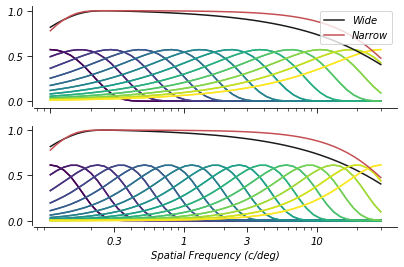

In [138]:
# Must specify LGN type (also fitType, but that won't matter here)
lgnFrontOn = 0;
fitType = 1; # flat, since it doesn't matter...
respMeasure = 0; # also doesn't matter
ths_plot = True;


saveName = '01_01_normPool_default%s%s.pdf' % ('_wLGNon' if lgnFrontOn else '', '_full' if not ths_plot else '')

mod_prms = all_fits[(lgnFrontOn, fitType)][ref_cellNum-1][hf_sfBB.get_resp_str(respMeasure)]['params']

ah = plot_norm_pool(mod_prms, trialInf, expInd, fitType=fitType, thesis_plot=ths_plot,
                    lgnFrontOn=lgnFrontOn, respMeasure=respMeasure); # default

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf();
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

#### What about the LGN front-end?

In [179]:
autoreload.reload(mrpt);

In [180]:
# load an example LGN fit!
lgnFrontOn, fitType = 4, 1;
lgn_fit = all_fits[(lgnFrontOn, fitType)][ref_cellNum-1][hf_sfBB.get_resp_str(respMeasure)]['params']
lgn_mod = mrpt.sfNormMod(lgn_fit, expInd, excType, normType=fitType, lossType=lossType, lgnFrontEnd=lgnFrontOn, newMethod=1, 
                          lgnConType=1, applyLGNtoNorm=1)


One version - show RVC, SF separately

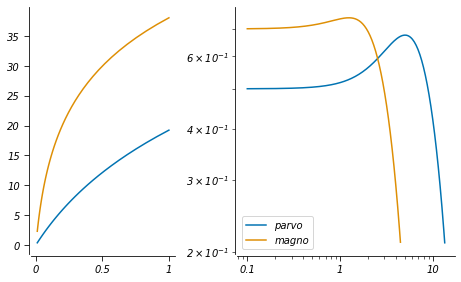

In [181]:
cns = mrpt._cast_as_tensor(np.geomspace(0.01, 1, 50));
prm_p = lgn_mod.rvc_p
prm_m = lgn_mod.rvc_m

sfs = mrpt._cast_as_tensor(np.geomspace(0.1, 30, 250));
prm_p_sf = lgn_mod.dog_p
prm_m_sf = lgn_mod.dog_m

f, ax = plt.subplots(1, 2, figsize=hf.set_size(tex_width), gridspec_kw={'width_ratios': [2, 3]})

# rvcs
prv = mrpt.get_rvc_model(prm_p, cns).detach().numpy()
mgn = mrpt.get_rvc_model(prm_m, cns).detach().numpy()
ax[0].plot(cns.detach().numpy(), prv, color=lgn_colors[0], label='parvo');
ax[0].plot(cns.detach().numpy(), mgn, color=lgn_colors[1], label='magno');
# ax[0].set_xscale('log')
# ax[0].set_yscale('log')

# sf
prv = mrpt.DiffOfGauss(*prm_p_sf, sfs).detach().numpy()
mgn = mrpt.DiffOfGauss(*prm_m_sf, sfs).detach().numpy()

plt_min = 0.2;

m_abv_min = mgn>plt_min
p_abv_min = prv>plt_min
ax[1].plot(sfs.detach().numpy()[p_abv_min], prv[p_abv_min], color=lgn_colors[0], label='parvo');
ax[1].plot(sfs.detach().numpy()[m_abv_min], mgn[m_abv_min], color=lgn_colors[1], label='magno');
ax[1].set_xscale('log');
ax[1].set_yscale('log');

ax[1].legend();

for i in range(2):
    for jj, axis in enumerate([ax[i].xaxis, ax[i].yaxis]):
        axis.set_major_formatter(FuncFormatter(lambda x,y: '%d' % x if x>=1 else '%d' % x if x==0 else '%.1f' % x)) # this will make everything in non-scientific notation!                                                                                                                 
#             core_ticks = np.array([1,3]);
#             pltd_sfs = all_sfs;
#             if np.min(pltd_sfs)<=0.4:
#                 core_ticks = np.hstack((0.3, core_ticks));
#             if np.max(pltd_sfs)>=7:
#                 core_ticks = np.hstack((core_ticks, 10));
#             axis.set_ticks(core_ticks)

sns.despine(offset=sns_offset)

f.tight_layout()


Second version - show SFs at different contrasts, implicitly showing RVC influence

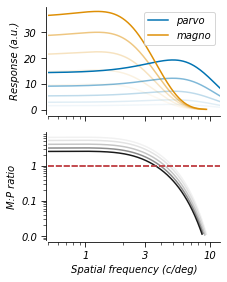

In [193]:
linY = True;

saveName = '01_02_lgnFrontEnd_%s_n%d%s.pdf' % (expDir.replace('/',''), ref_cellNum, '_linY' if linY else '')


cns = mrpt._cast_as_tensor(np.geomspace(0.01, 1, 50));
prm_p = lgn_mod.rvc_p
prm_m = lgn_mod.rvc_m

sfs = mrpt._cast_as_tensor(np.geomspace(0.5, 30, 250));
prm_p_sf = lgn_mod.dog_p
prm_m_sf = lgn_mod.dog_m

f, ax = plt.subplots(2, 1, sharex=True, figsize=hf.set_size(0.5*tex_width, extra_height=2))
#             , gridspec_kw={'height_ratios': [5, 3]})

# rvcs
prv_rvc = mrpt.get_rvc_model(prm_p, cns).detach().numpy()
mgn_rvc = mrpt.get_rvc_model(prm_m, cns).detach().numpy()

# sf
prv = mrpt.DiffOfGauss(*prm_p_sf, sfs).detach().numpy()
mgn = mrpt.DiffOfGauss(*prm_m_sf, sfs).detach().numpy()
prv = np.divide(prv, np.max(prv)) # we can normalize by max of the samples (rather than computing separate set to norm. by) since we finely sample here
mgn = np.divide(mgn, np.max(mgn)) # we can normalize by max of the samples (rather than computing separate set to norm. by) since we finely sample here

plt_min = 0.05;

plt_cons = [0.06, 0.12, 0.25, 0.5, 1]
for iii,con in enumerate(plt_cons):

    m_rvc_curr = mrpt.get_rvc_model(prm_m, mrpt._cast_as_tensor(con)).detach().numpy()
    p_rvc_curr = mrpt.get_rvc_model(prm_p, mrpt._cast_as_tensor(con)).detach().numpy()
    
    mgn_curr = mgn * m_rvc_curr
    prv_curr = prv * p_rvc_curr
    
    m_abv_min = mgn_curr>plt_min
    p_abv_min = prv_curr>plt_min
    if iii==(len(plt_cons)-1): # only label once
        ax[0].plot(sfs.detach().numpy()[p_abv_min], prv_curr[p_abv_min], color=lgn_colors[0], alpha=con, label='parvo');
        ax[0].plot(sfs.detach().numpy()[m_abv_min], mgn_curr[m_abv_min], color=lgn_colors[1], alpha=con, label='magno');
    else:
        ax[0].plot(sfs.detach().numpy()[p_abv_min], prv_curr[p_abv_min], color=lgn_colors[0], alpha=con);
        ax[0].plot(sfs.detach().numpy()[m_abv_min], mgn_curr[m_abv_min], color=lgn_colors[1], alpha=con);
    ax[0].set_xscale('log');
    if not linY:
        ax[0].set_yscale('log');

    # AND in the second plot, show the ratio of M:P across frequency
    rat_curr = mgn_curr/prv_curr;
    abv_min = rat_curr>1e-2
    ax[1].plot(sfs.detach().numpy()[abv_min], rat_curr[abv_min], alpha=con, color='k')
    ax[1].set_yscale('log')
#     ax[1].set_ylim([5e-1, 15])
    ax[1].axhline(1, color='r', linestyle='--')
    if iii==0:
        ax[1].set_ylabel('M:P ratio')
        ax[0].set_ylabel('Response (a.u.)')

ax[0].legend();

sf_min, sf_max = sfs.detach().numpy()[0], sfs.detach().numpy()[-1]
for i in range(2):
            
    if i==1:
        ax[i].set_xlabel('Spatial frequency (c/deg)')
    
    ax[i].set_xlim([sf_min, np.minimum(12, sf_max)])
    for jj, axis in enumerate([ax[i].xaxis, ax[i].yaxis]):
        axis.set_major_formatter(FuncFormatter(lambda x,y: '%d' % x if x>=1 else '%d' % x if x==0 else '%.1f' % x)) # this will make everything in non-scientific notation!
        if jj == 0: # i.e. x-axis
            core_ticks = np.array([1,3,10]);
            axis.set_ticks(core_ticks)

sns.despine(offset=sns_offset)

f.tight_layout()

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf();
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

Third version: As above, but also have together plot at a few contrasts

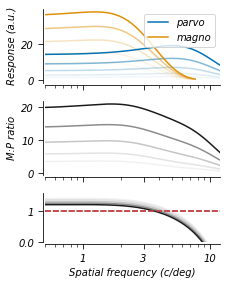

In [171]:
linY = True;

saveName = '01_02a_lgnFrontEnd_wCombo_%s_n%d%s.pdf' % (expDir.replace('/',''), ref_cellNum, '_linY' if linY else '')


cns = mrpt._cast_as_tensor(np.geomspace(0.01, 1, 50));
prm_p = lgn_mod.rvc_p
prm_m = lgn_mod.rvc_m

sfs = mrpt._cast_as_tensor(np.geomspace(0.5, 30, 250));
prm_p_sf = lgn_mod.dog_p
prm_m_sf = lgn_mod.dog_m
# prm_m_sf[1] = 1.2*prm_m_sf[1]

nrow=3

f, ax = plt.subplots(nrow, 1, sharex=True, figsize=hf.set_size(0.5*tex_width, extra_height=2)#)
                      , gridspec_kw={'height_ratios': [3,3,2]})

# rvcs
prv = mrpt.get_rvc_model(prm_p, cns).detach().numpy()
mgn = mrpt.get_rvc_model(prm_m, cns).detach().numpy()

# sf
prv = mrpt.DiffOfGauss(*prm_p_sf, sfs).detach().numpy()
mgn = mrpt.DiffOfGauss(*prm_m_sf, sfs).detach().numpy()
prv = np.divide(prv, np.max(prv)) # we can normalize by max of the samples (rather than computing separate set to norm. by) since we finely sample here
mgn = np.divide(mgn, np.max(mgn)) # we can normalize by max of the samples (rather than computing separate set to norm. by) since we finely sample here

plt_min = 0.5;

plt_cons = [0.06, 0.12, 0.25, 0.5, 1]
for iii,con in enumerate(plt_cons):

    mgn_curr = mgn * mrpt.get_rvc_model(prm_m, mrpt._cast_as_tensor(con)).detach().numpy()
    prv_curr = prv * mrpt.get_rvc_model(prm_p, mrpt._cast_as_tensor(con)).detach().numpy()
    
    m_abv_min = mgn_curr>plt_min
    p_abv_min = prv_curr>plt_min
    if iii==(len(plt_cons)-1): # only label once
        ax[0].plot(sfs.detach().numpy()[p_abv_min], prv_curr[p_abv_min], color=lgn_colors[0], alpha=con, label='parvo');
        ax[0].plot(sfs.detach().numpy()[m_abv_min], mgn_curr[m_abv_min], color=lgn_colors[1], alpha=con, label='magno');
    else:
        ax[0].plot(sfs.detach().numpy()[p_abv_min], prv_curr[p_abv_min], color=lgn_colors[0], alpha=con);
        ax[0].plot(sfs.detach().numpy()[m_abv_min], mgn_curr[m_abv_min], color=lgn_colors[1], alpha=con);
    ax[0].set_xscale('log');
    if not linY:
        ax[0].set_yscale('log');

    # AND in the second plot, show the ratio of M:P across frequency
    rat_curr = mgn_curr/prv_curr;
    ax[2].plot(sfs.detach().numpy(), rat_curr, alpha=con, color='k')
    ax[2].set_yscale('log')
    ax[2].set_ylim([1e-2, 15])
    ax[2].axhline(1, color='r', linestyle='--')
    if iii==0:
        ax[1].set_ylabel('M:P ratio')
        ax[0].set_ylabel('Response (a.u.)')
        
    # AND in the 3rd plot, show M+P together for a few diff. cons
    mWt = 0.25;
    together = mWt*mgn_curr + (1-mWt)*prv_curr
    t_abv_min = together>plt_min
    ax[1].plot(sfs.detach().numpy()[t_abv_min], together[t_abv_min], color='k', alpha=con);
    if not linY:
        ax[1].set_yscale('log');


ax[0].legend();

sf_min, sf_max = sfs.detach().numpy()[0], sfs.detach().numpy()[-1]

for i in range(nrow):

    if i==(nrow-1):
        ax[i].set_xlabel('Spatial frequency (c/deg)')
    
    ax[i].set_xlim([sf_min, np.minimum(12, sf_max)])
    for jj, axis in enumerate([ax[i].xaxis, ax[i].yaxis]):
        axis.set_major_formatter(FuncFormatter(lambda x,y: '%d' % x if x>=1 else '%d' % x if x==0 else '%.1f' % x)) # this will make everything in non-scientific notation!
        if jj == 0: # i.e. x-axis
            core_ticks = np.array([1,3,10]);
            axis.set_ticks(core_ticks)

sns.despine(offset=sns_offset)

f.tight_layout()


# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf();
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

#### Do we actually have good/representative LGN parameters?

dog_mech is organized as: 'gc', 'rc', 'vc', 'gs', 'rs', 'vs'

**IGNORE: NOT WORTH IT FOR THESIS**


In [42]:
# dog_mechs = hf.jl_get_metric_byCon(lgn, 'dog_mech', conVal=1, disp=0)[0]

# lgn_gc = dog_mechs[:,0]
# lgn_rc = dog_mechs[:,1]
# lgn_gs = dog_mechs[:,3]
# lgn_rs = dog_mechs[:,4]

In [43]:
# df_lgn = df[df['area']=='lgn']
# df_lgn['gc'] = lgn_gc
# df_lgn['rc'] = lgn_rc
# df_lgn['gs'] = lgn_gs
# df_lgn['rs'] = lgn_rs

# df_lgn['ks_kc'] = (lgn_gs/np.square(lgn_rs))/(lgn_gc/np.square(lgn_rc))
# df_lgn['rs_rc'] = lgn_rs/lgn_rc

# df_rel_subset = df_lgn[['cellType', 'gc', 'rc', 'gs', 'rs', 'ks_kc', 'rs_rc']]


### Note, 23.01.30 --> could add here for excitatory filter, too? Tuning of gain control as well, rather than just showing normalization response

# Interlude - Make the V1 datalist

In [1054]:
v1 = hf.np_smart_load('jointList_wMods_V1_230201vE_vT00_dvT00_m3j10.npy')

# create the sfBB-only subset of the jointList (v1)
ohno = pd.DataFrame.from_dict(v1)
meta = pd.json_normalize([ohno[x]['metadata'] for x in sorted(ohno.keys())])
metr = pd.json_normalize([ohno[x]['metrics'] for x in sorted(ohno.keys())])
modl = pd.json_normalize([ohno[x]['model'] for x in sorted(ohno.keys())])
supr = pd.json_normalize([ohno[x]['superpos'] for x in sorted(ohno.keys())])
basc = pd.json_normalize([ohno[x]['basics'] for x in sorted(ohno.keys())])

v1_pd = pd.concat((meta, metr, modl, supr, basc), axis=1);
# keep the index into the overall jointlist...

respStr_print = lambda x: 'simple' if x==1 else 'complex'
v1_pd['respMeasurePrint'] = v1_pd['respMeasure'].apply(respStr_print)

# trim some annoying/irrelevant keys
to_trim = ['sfCom', 'lsfv', 'dog_mech', 'sfVar', 'sf70', 'sfE', 'bw34', 'tf1', 'rvc1', 'sf1']
for rmv in to_trim:
    kys = list(v1_pd.keys());
    to_drop = [rmv in x for x in kys];
    [v1_pd.drop(kys[drp], axis=1, inplace=True) for drp in np.where(to_drop)[0]]

which_respMeasure = v1_pd.respMeasure;
which_respStr = [hf_sfBB.get_resp_str(x) for x in which_respMeasure]

Also get some measures that are easier to evaluate from the jointList

In [1065]:
which_jl = v1;

vExp_clip = -10

# other metrics, eval. @ highest contrast
hiCon_varExpl = hf.jl_get_metric_byCon(which_jl, 'dog_varExpl', conVal=1, disp=0)[0] # highest con.
bwHalf = hf.jl_get_metric_byCon(which_jl, 'dog_bwHalf', conVal=1, disp=0)[0]
charFreq = hf.jl_get_metric_byCon(which_jl, 'dog_charFreq', conVal=1, disp=0)[0] # highest con.
prefSf = hf.jl_get_metric_byCon(which_jl, 'dog_pSf', conVal=1, disp=0)[0] # highest con.
# ---- and add to df
v1_pd['charFreq_hiCon'] = charFreq;
v1_pd['prefSf_hiCon'] = prefSf;
v1_pd['bwHalf_hiCon'] = bwHalf;
v1_pd['sfVarExpl_hiCon'] = hiCon_varExpl;
v1_pd['sfVarExpl_hiCon_clip'] = v1_pd['sfVarExpl_hiCon'].apply(lambda x: np.clip(x, vExp_clip, None)  if ~np.isnan(x) else np.nan)

# unpack mean/median/max
mn_med_max = hf.jl_get_metric_byCon(which_jl, 'mn_med_max', conVal=None, disp=None)[0]
mn, md, mx = np.transpose(mn_med_max);
# ----- and drop the joint column
v1_pd['meanResp'] = mn
v1_pd['medianResp'] = md
v1_pd['maxResp'] = mx
try:
    v1_pd.drop('mn_med_max', axis=1, inplace=True)
except:
    pass; # then we've already dropped it anyway

# c50 stuff (from superposition)
c50_pref = hf.jl_get_metric_byCon(which_jl, ['disp0_c50'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
c50_pref_emp = hf.jl_get_metric_byCon(which_jl, ['disp0_c50_emp'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
v1_pd['c50_pref'] = c50_pref
v1_pd['c50_pref_emp'] = c50_pref_emp
# --- AND make the expDir easier
v1_pd['expDir'] = v1_pd['fullPath'].apply(lambda x: x.split('/')[-3])


#####
# mixture metrics (as applicable)
#####
sfErrs_boot = hf.jl_get_metric_byCon(which_jl, ['sfErrsInd_wtdVar_prince_boot'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
sfErrs_boot_std = np.nanstd(sfErrs_boot, axis=1)
sfErrs_boot_mdn = np.nanmedian(sfErrs_boot, axis=1)
super_varExpl_boot = hf.jl_get_metric_byCon(which_jl, ['var_expl_boot'], conVal=None, disp=None, fieldOverwrite='superpos')[0]
super_varExpl_std = np.nanstd(super_varExpl_boot, axis=1)
super_varExpl_std_clip = np.nanstd(np.clip(super_varExpl_boot, -50, None), axis=1)
auc_boot_std = np.nanstd(hf.jl_get_metric_byCon(which_jl, ['supr_area_boot'], conVal=None, disp=None, fieldOverwrite='superpos')[0], axis=1)

full_disps = [np.logical_and('sfErrsInd_var_prince' in v1[x]['superpos'], len(v1[x]['metadata']['stimVals'][0])>2) for x in v1.keys()];

# cut out bad cells...
threshPass = np.logical_and(full_disps, np.sum(super_varExpl_boot>vThresh, axis=1)>(0.95*super_varExpl_boot.shape[1]))
# --- also make sure that sfErrs_boot_std>0, b/c ==0 only if there are no repeats!
threshPass = np.logical_and(threshPass, sfErrs_boot_std>0)


#####
# masking metrics (as applicable) 
# --- unbelievably messy/sloppy code, but we get any relevant masking metrics, put them back into the full dataframe
#####
analysis_date = '230125' # 23 was the standard
sfBB = hf.np_smart_load('V1_BB/structures/sfBB_analysis_%s.npy' % analysis_date)

sfBB_pd = pd.DataFrame.from_dict(sfBB, orient='index')
sfBB_pd.rename(columns={'f1f0_ratio': 'f1f0_ratio_notJL'}, inplace=True)
dcs = pd.json_normalize(sfBB_pd['dc'])
sfBB_pd.drop('dc', axis=1, inplace=True)
f1s = pd.json_normalize(sfBB_pd['f1'])
f1s.rename(columns={'baseResp_circVar': 'baseVarEst'}, inplace=True)
sfBB_pd.drop('f1', axis=1, inplace=True)
# first rename so that we can create one df with both DC and F1 values
dcs_rename = dcs.rename(columns = {x: 'dc_%s' % x for x in dcs.columns}, inplace = False)
f1s_rename = f1s.rename(columns = {x: 'f1_%s' % x for x in f1s.columns}, inplace = False)
# now, go through and grab DC/F1, correspondingly
# --- first, add the independent-of-respMeasure stuff (sfBB_pd after dropping 'dc'/'f1' fields)
# --- and add cellNum index so that we can join properly
nCellsBB = len(sfBB.keys())
sfBB_pd.insert(0, 'cellNum', range(1,1+nCellsBB))
sfBB_pd.set_index('cellNum', inplace=True)
is_BB = ['BB' in x for x in v1_pd['fullPath']]
v1_bb_pd = v1_pd[is_BB]
sfBB_pd_correct = v1_bb_pd.join(sfBB_pd, on='cellNum')
# --- now add the correct measure (start by just copying the DC) 
# ______ NOTE: just a subset of all keys ()
corr_subset = dcs[['sfPref','baseDiffs', 'baseResp_mean', 'baseResp_std', 'baseResp_fano']].copy()
# we'll rename the baseResp_std column to represent variance of the base response generally
# --- for F1, this will be the circular variance of the response phase
corr_subset.rename(columns={'baseResp_fano': 'baseVarEst'}, inplace=True)
which_respMeasure_BB = v1_bb_pd.respMeasure;
for iii, respMeasure in enumerate(which_respMeasure_BB):
    if respMeasure==1: # i.e F1, then we need to overwrite
        corr_subset.iloc[iii] = f1s[['sfPref','baseDiffs', 'baseResp_mean', 'baseResp_std', 'baseVarEst']].iloc[iii]
corr_subset.insert(0, 'cellNum', range(1,1+nCellsBB))
corr_subset.set_index('cellNum', inplace=True)
corr_subset = sfBB_pd.join(corr_subset, on='cellNum')
corr_subset.set_index(v1_bb_pd.index, inplace=True)
corr_subset['maskSf_relPref'] = corr_subset['maskSf']/corr_subset['sfPref']
# what percentage of the max. response was the base stimulus?
corr_subset['baseAsMaxFrac'] = corr_subset['baseResp_mean']/v1_bb_pd['maxResp']
corr_subset['baseAsMeanFrac'] = corr_subset['baseResp_mean']/v1_bb_pd['meanResp']

# now add 
v1_pd_all = v1_pd.join(corr_subset)

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [1373]:
v1_pd['ref_mod_vExp'] = v1_pd['varExplAll'].apply(lambda x: x[0] if x is not None else np.nan)
mod_vExp_clip = -10
v1_pd['ref_mod_vExp_clip'] = v1_pd['ref_mod_vExp'].apply(lambda x: np.clip(x, vExp_clip, None)  if ~np.isnan(x) else np.nan)
v1_pd['best_mod_vExp'] = v1_pd['varExplAll'].apply(lambda x: np.nanmax(x) if x is not None else np.nan)
v1_pd['ref_mod_NLL'] = v1_pd['NLLs'].apply(lambda x: x[0] if x is not None else np.nan)
v1_pd['ref_mod_NLL_tr'] = v1_pd['NLLs_CV_tr'].apply(lambda x: x[0] if x is not None else np.nan)
v1_pd['ref_mod_NLL_te'] = v1_pd['NLLs_CV_te'].apply(lambda x: x[0] if x is not None else np.nan)

# let's also add wt and wtMtch for now... (with no LGN)
lI = 0;
nms = ['wt', 'wtMtch']
nI = [2,7]
for nm_,nI_ in zip(nms, nI):
    normOK =  np.where(modsAll[akey]['model']['inputsSpecified']['normType'] == nI_);
    lgnOK =  np.where(modsAll[akey]['model']['inputsSpecified']['lgnFrontEnd'] == lI);
    curr_mod_ind = np.intersect1d(lgnOK, normOK)[0];
    
    v1_pd['%s_mod_vExp' % nm_] = v1_pd['varExplAll'].apply(lambda x: x[curr_mod_ind] if x is not None else np.nan)
    v1_pd['%s_mod_NLL' % nm_] = v1_pd['NLLs'].apply(lambda x: x[curr_mod_ind] if x is not None else np.nan)
    v1_pd['%s_mod_NLL_te' % nm_] = v1_pd['NLLs_CV_te'].apply(lambda x: x[curr_mod_ind] if x is not None else np.nan)


A quick look at which cells are poorly accounted for by the model?

In [1374]:
v1_pd[v1_pd['best_mod_vExp']<50][['expDir', 'cellNum', 'maxResp', 'meanResp', 'respMeasure', 'ref_mod_vExp', 'wt_mod_vExp', 'sfVarExpl_hiCon']]

,expDir,cellNum,maxResp,meanResp,respMeasure,ref_mod_vExp,wt_mod_vExp,sfVarExpl_hiCon
11,V1_orig,12,3.100,0.475,0,33.542,32.279,91.815
18,V1_orig,19,11.700,4.138,0,10.873,16.262,43.840
24,V1_orig,25,31.300,10.855,0,45.230,47.405,3.817
36,V1_orig,37,9.200,1.240,0,45.024,44.510,72.087
66,altExp,8,48.100,26.390,0,-115.320,-84.138,-2.765
67,V1,1,35.900,14.442,1,33.764,31.584,92.926
68,V1,2,11.700,5.617,0,32.357,33.799,60.848
70,V1,4,24.900,13.828,1,38.943,39.363,64.272
75,V1,9,16.600,6.688,1,8.189,6.356,78.541
77,V1,11,44.800,28.852,1,-35.057,-28.711,82.189


As it turns out, some of these are truly bad/noisy data (e.g. V1_BB/47, V1/11) or low firing rates (e.g. V1_BB/9, V1_orig/12) while others are just reflective of the difficulty in a one-size-fits-all calculation of varExpl. In particular, some DC cells with a high baseline and little modulation are decently fit but show with poor varExpl (e.g. V1_orig/25, V1/39, V1/34 {bad vExp in part due to low firing rates})

In [1036]:
np.sum(v1_pd['best_mod_vExp']<50)

32

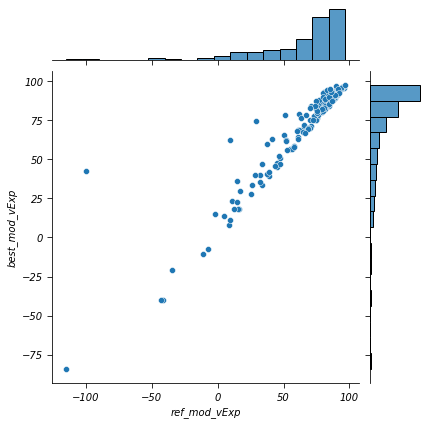

In [1033]:
sns.jointplot(data=v1_pd, x='ref_mod_vExp', y='best_mod_vExp')

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='maxResp', ylabel='Density'>

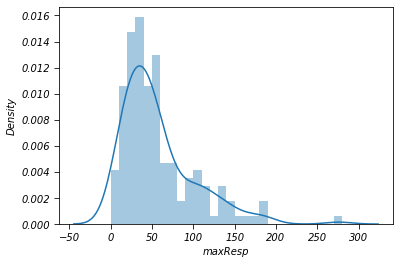

In [1019]:
sns.distplot(v1_pd['maxResp'], bins=np.arange(0,300,10))

In [896]:
# useful code to check for what a given key is called...
kys = list(v1_pd_all.keys())
oks = np.where(['var' in x for x in kys])[0]
[kys[x] for x in oks]
oks = np.where(['Var' in x for x in kys])[0]
[kys[x] for x in oks]

['sfVarExpl_hiCon', 'baseVarEst']

# 2. Analysis: cross-validation

##### Use the jointLists

In [993]:
# NOTE: modsAll_full is ALL cells; modsAll is just those with valid NLLs

modsAll_full = hf.np_smart_load('jointList_wMods_V1_230131vE_vT00_dvT00_m3j10.npy')
# OPTIONALLY, remove any Nones...
valids = np.where([~np.all(np.isnan(modsAll[x]['model']['NLLs'])) for x in modsAll_full.keys()])[0];
modsAll = {i: modsAll_full[k] for i,k in enumerate(valids)};

expNames = np.array([modsAll[x]['metadata']['fullPath'].split('/')[-3] for x in modsAll.keys()]);

In [994]:
# first load normal/full-dataset NLL
NLLs = np.array([np.array(modsAll[x]['model']['NLLs']) for x in modsAll.keys()]);
# then, C-V
NLLs_tr = np.array([np.array(modsAll[x]['model']['NLLs_CV_tr']) for x in modsAll.keys()]);
NLLs_te = np.array([np.array(modsAll[x]['model']['NLLs_CV_te']) for x in modsAll.keys()]);
# and varExpl
varExpl = np.array([np.array(modsAll[x]['model']['varExplAll']) for x in modsAll.keys()]);
varExpl_CV = np.array([np.array(modsAll[x]['model']['varExplAll_CV']) for x in modsAll.keys()]);

get_ref_key = hf.modelSpecs_to_key(1, 1, 0); # flat; loss=1; no LGN [0]; all other params as default
akey = list(modsAll.keys())[0]; # all the same...
ref_index = np.where([x==get_ref_key for x in modsAll[akey]['model']['inputKeys']])[0]

# let's make these [...,3] with the indices as below:
rawInd, normInd, percInd = 0,1,2;

# --- set it up
all_NLLs = np.repeat(np.expand_dims(NLLs, axis=-1), 3, axis=-1)
all_NLLs_tr = np.repeat(np.expand_dims(NLLs_tr, axis=-1), 3, axis=-1)
all_NLLs_te = np.repeat(np.expand_dims(NLLs_te, axis=-1), 3, axis=-1)
# --- then overwrite norm, perc indices
all_NLLs[:,:,normInd] /= all_NLLs[:,ref_index,normInd]
all_NLLs_tr[:,:,normInd] /= all_NLLs_tr[:,ref_index,normInd]
all_NLLs_te[:,:,normInd] /= all_NLLs_te[:,ref_index,normInd]
as_perc = lambda ref,upd: 100*(ref-upd)/ref
all_NLLs[:,:,percInd] = as_perc(all_NLLs[:,ref_index,0], all_NLLs[:,:,0])
all_NLLs_tr[:,:,percInd] = as_perc(all_NLLs_tr[:,ref_index,0], all_NLLs_tr[:,:,0])
all_NLLs_te[:,:,percInd] = as_perc(all_NLLs_te[:,ref_index,0], all_NLLs_te[:,:,0])


#### Relative improvement compared to flat model

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice


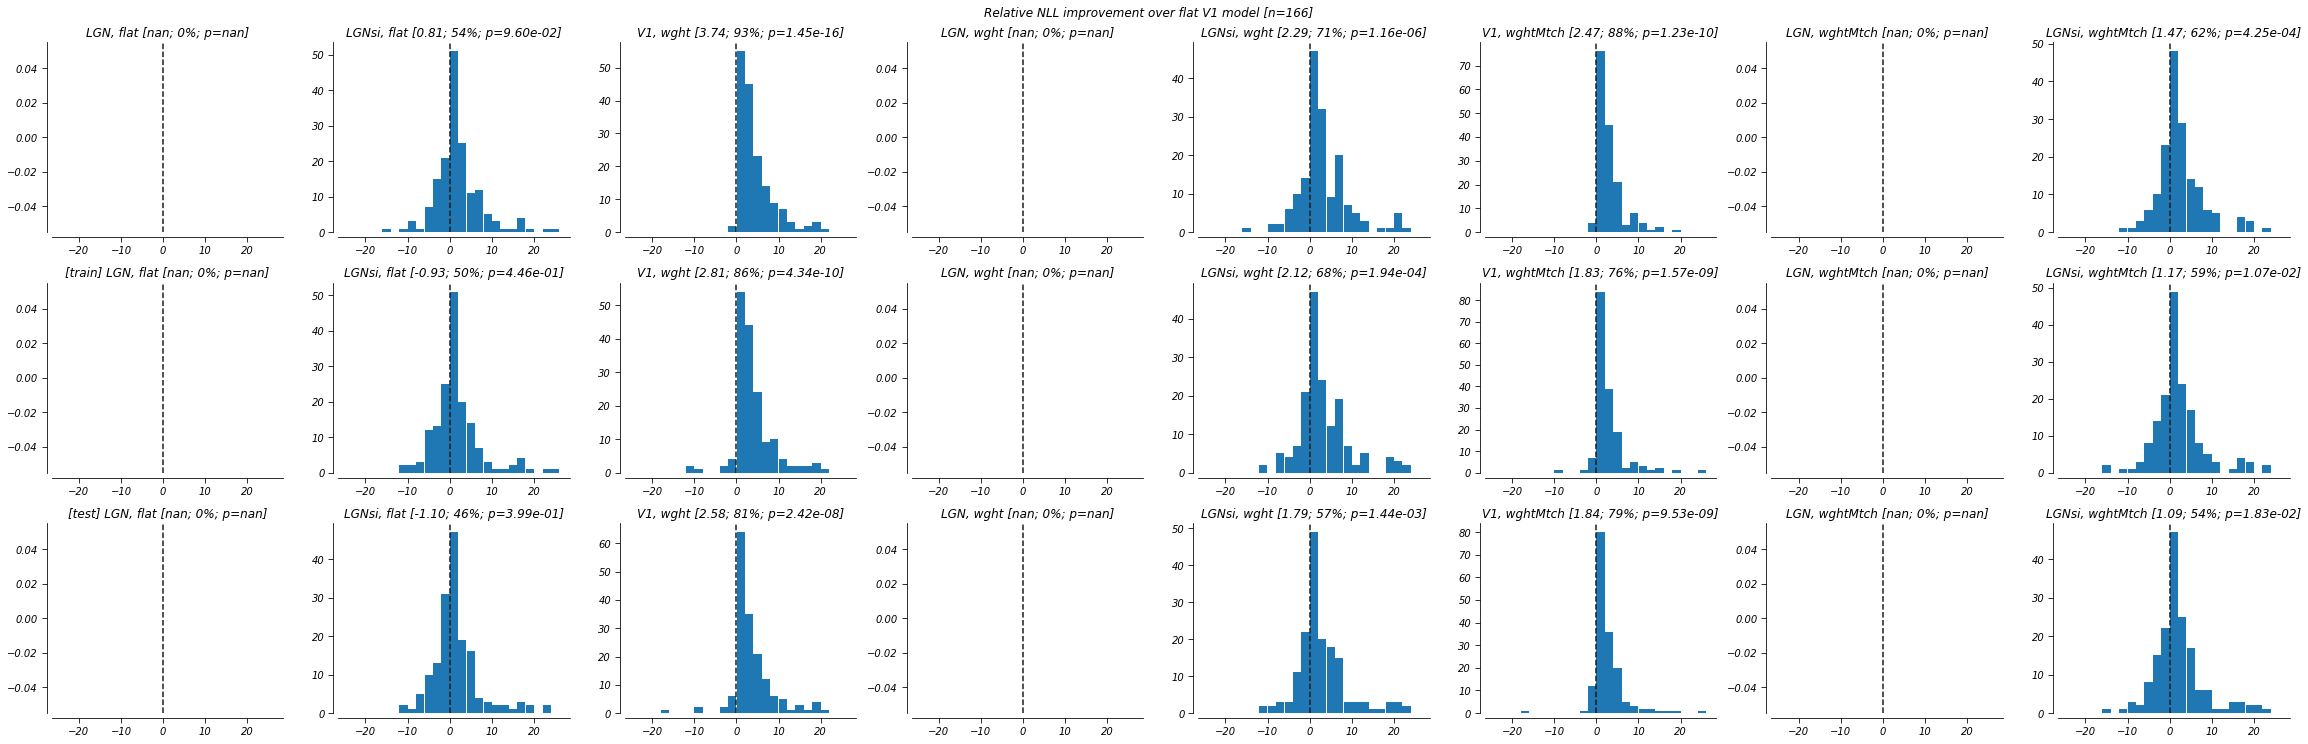

In [995]:
# val_expt = ['altExp', 'V1']; # this will prob. be only one we combine
# val_expt = ['altExp'];
val_expt = None

bin_finer = 1; # 

saveName = '02_01_NLLall_relImprHist%s%s.pdf' % ('_only%s' % ''.join(val_expt) if val_expt is not None else '',
                                                '_finerBins' if bin_finer else '')

nMods = NLLs.shape[-1];
nOtherMods = nMods - 1; # remove the reference as one model
nComps = 3; # not-CV, train, test

f, ax = plt.subplots(nComps, nOtherMods, figsize=(4*nOtherMods, 3.5*nComps));

bins = np.linspace(-25,25,26) if bin_finer==1 else np.linspace(-40,40,21);
dataOrg = [all_NLLs, all_NLLs_tr, all_NLLs_te]
rowStr = ['', '[train] ', '[test] '];

for (comp_i, data), rowStr in zip(enumerate(dataOrg), rowStr):
    val_mod = 0;
    for i_mod in range(nMods):
        if i_mod == ref_index:
            continue; # don't plot this one...
        lVal, nVal = modsAll[akey]['model']['inputsSpecified']['lgnFrontEnd'][i_mod], modsAll[akey]['model']['inputsSpecified']['normType'][i_mod]

        lgnStr = hf.lgnType_suffix(lVal).replace('_','');
        lgnStr = 'V1' if lgnStr=='' else lgnStr;
        normModStr = hf.fitType_suffix(nVal).replace('_','')

        if val_expt is None:
            val_cells = range(data.shape[0]);
        else:
            val_cells = []
            for expt_curr in val_expt:
                val_cells = np.concatenate((val_cells, np.where(expNames==expt_curr)[0]));
            val_cells = np.array(val_cells, dtype=np.int)
        
        cnts,bns = np.histogram(data[val_cells, i_mod, percInd], bins=bins)

        ax[comp_i, val_mod].bar(bns[1:], cnts, width=1.95)
        ax[comp_i, val_mod].axvline(0, color='k', linestyle='--')
        rowStr = rowStr if val_mod==0 else ''
        percWinners = 100*np.sum(data[val_cells, i_mod, percInd]>0)/len(data[val_cells, i_mod, percInd])
        ttest = ss.ttest_1samp(data[val_cells, i_mod, percInd], popmean=0)
        ax[comp_i, val_mod].set_title('%s%s, %s [%.2f; %d%%; p=%.2e]' % (rowStr, lgnStr, 
                                                                 normModStr, 
                                                                 np.nanmean(data[val_cells, i_mod, percInd]),
                                                                 percWinners, ttest.pvalue))

        val_mod+=1
    
sns.despine(offset=5);
f.suptitle('Relative NLL improvement over flat V1 model [n=%d]' % len(val_cells))
f.tight_layout()

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

### Impressions:
- The largest _mean_ improvement goes to the V1 wght model (tuned gain control).
- All models are better than flat, with the slight exception (_maybe_? of the LGNsi model with no tuned gain control)

##### Now compare between pairs of models
We'll try to highlight some of the outlier cells so we can show examples!

### 2.1 Comparisons on absolute NLL 

In [215]:
lgnVal_a, normVal_a = 0, 1; # only these two values are needed to uniquely specify a model run/fit
lgnVal_b, normVal_b = 0, 2; # only these two values are needed to uniquely specify a model run/fit

### 2.2 Comparisons on impr. rel to reference model

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: All-NaN slice encountered


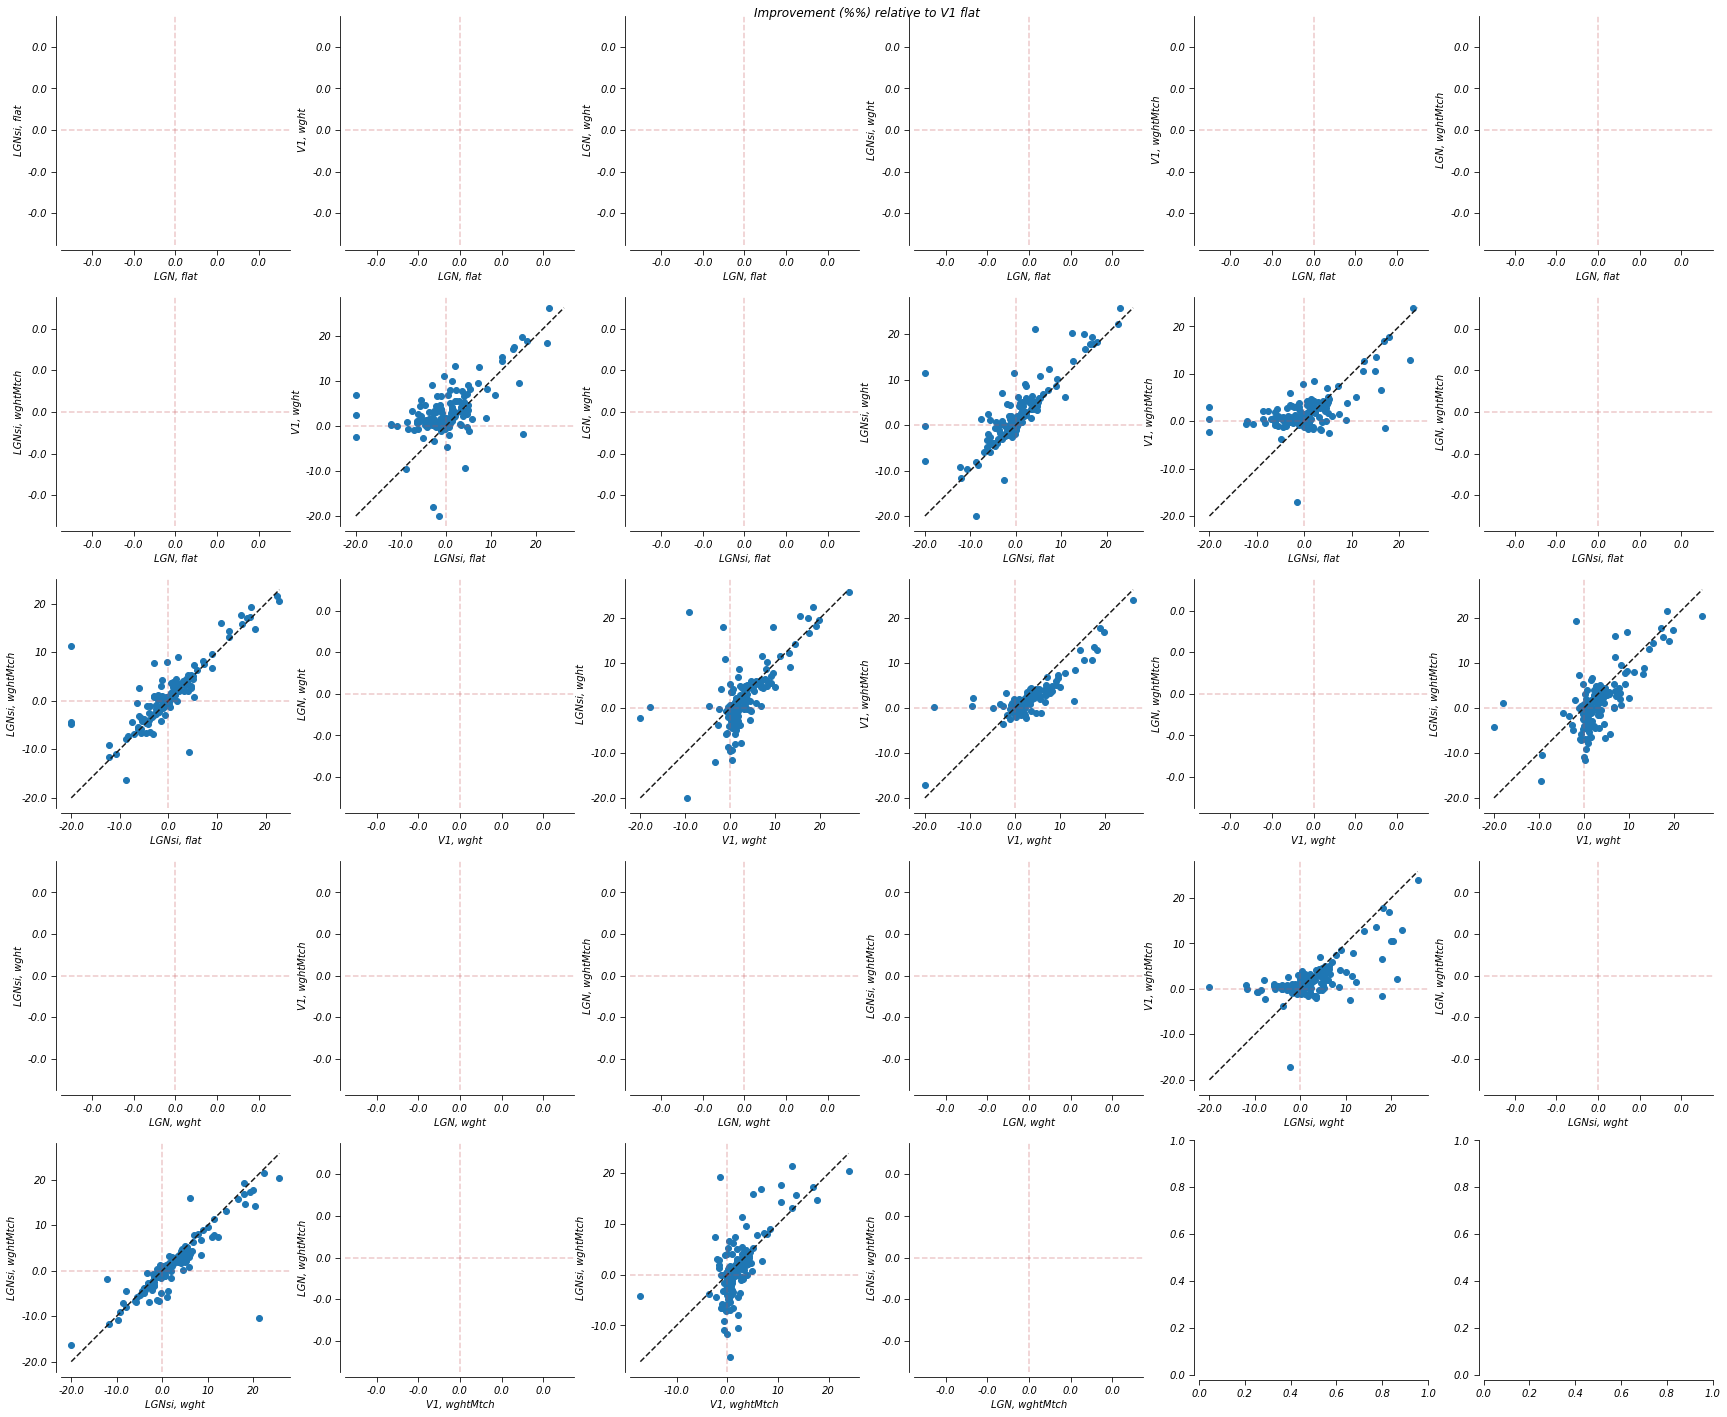

In [983]:
which_data = 2; # 0/1/2 (non-CV/train/test)
dataStr = '_cvTest' if which_data==2 else '_cvTrain' if which_data==1 else '';

curr_data = dataOrg[which_data];

saveName = '02_02_percNLL_scatter%s.pdf' % dataStr

nPlts = nOtherMods*(nOtherMods-1)/2; # pairwise combinations, div by 2 (ab vs ba are the same...)

nrow = int(np.floor(np.sqrt(nPlts)))
ncol = int(np.ceil(nPlts/nrow));

f, ax = plt.subplots(nrow,ncol,figsize=(4*ncol,4*nrow));

val_mods = np.setxor1d(range(nMods), ref_index)
low_clip = -20 # prct

for iii,(modA,modB) in enumerate(itertools.combinations(val_mods, 2)):

    row_ind = int(iii/ncol);
    col_ind = np.mod(iii, ncol);
    # temporarily to avoid bad scales, make the minimum no smaller than X
    mn = np.maximum(low_clip, np.minimum(np.nanmin(curr_data[:,modA,percInd]), np.nanmin(curr_data[:,modB,percInd])))
#     mn = np.minimum(np.nanmin(curr_data[:,modA,percInd]), np.nanmin(curr_data[:,modB,percInd]))
    mx = np.maximum(np.nanmax(curr_data[:,modA,percInd]), np.nanmax(curr_data[:,modB,percInd]))

    lgnStrs = []; normStrs = [];
    for modN in [modA,modB]:
        lVal, nVal = modsAll[akey]['model']['inputsSpecified']['lgnFrontEnd'][modN], modsAll[akey]['model']['inputsSpecified']['normType'][modN]
        lgnStr = hf.lgnType_suffix(lVal).replace('_','');
        lgnStr = 'V1' if lgnStr=='' else lgnStr;
        normModStr = hf.fitType_suffix(nVal).replace('_','')
        lgnStrs.append(lgnStr);
        normStrs.append(normModStr)

    ax[row_ind, col_ind].set_xlabel('%s, %s' % (lgnStrs[0], normStrs[0]))
    ax[row_ind, col_ind].set_ylabel('%s, %s' % (lgnStrs[1], normStrs[1]))
    ax[row_ind, col_ind].plot([mn,mx], [mn,mx], 'k--');
    ax[row_ind, col_ind].scatter(np.clip(curr_data[:,modA,percInd], low_clip, None), 
                                 np.clip(curr_data[:,modB,percInd], low_clip, None));
#     ax[row_ind, col_ind].scatter(curr_data[:,modA,percInd], curr_data[:,modB,percInd]);
    ax[row_ind, col_ind].axis('scaled')
    # and zero lines
    ax[row_ind, col_ind].axhline(0, color='r', linestyle='--', alpha=0.3)
    ax[row_ind, col_ind].axvline(0, color='r', linestyle='--', alpha=0.3)
    
    for jj, axis in enumerate([ax[row_ind, col_ind].xaxis, ax[row_ind, col_ind].yaxis]):
        axis.set_major_formatter(FuncFormatter(lambda x,y: '%d' % x if x>=1 else '%.1f' % x)) # this will make everything in non-scientific notation!
        if jj==1: # i.e. y axis, make sure we have tick labels, here, too
            axis.set_tick_params(labelleft=True); 

f.suptitle('Improvement (%%) relative to V1 flat')
f.tight_layout();
sns.despine(offset=5);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

In [483]:
### For example, what about LGNsi where wght is much better than flat?
lgnInds = [0,0]; # none/on/shift [0/1/4]
normInds = [2,7]; # flat [1], wght [2]

abs_order = True;

nlls_curr = [];

for nI,lI in zip(normInds, lgnInds):
    normOK = np.where(modsAll[akey]['model']['inputsSpecified']['normType'] == nI);
    lgnOK = np.where(modsAll[akey]['model']['inputsSpecified']['lgnFrontEnd'] == lI);
    curr_mod = np.intersect1d(lgnOK, normOK);
    
    nlls_curr.append(curr_data[:, curr_mod, percInd])
diffs = np.subtract(*nlls_curr).flatten()
# Here, negative values mean the second model has a higher improvement over the flat model, as compared to first model
if abs_order:
    asort = np.argsort(-np.abs(diffs))
else:
    asort = np.argsort(diffs)


V1:11
V1:39
V1:17
V1:43
V1:35


<>:30: DeprecationWarning: invalid escape sequence \_


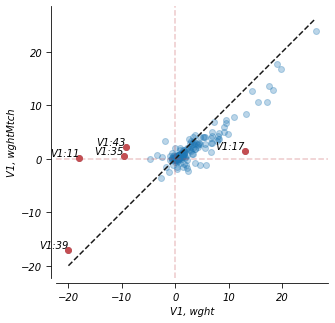

In [484]:
howMany = 5;
strt = 0
whichOnes = np.arange(strt,strt+howMany)

# plt.stem(diffs[am][np.abs(diffs[am])>5])
f = plt.figure(figsize=(5,5))

mn = np.maximum(low_clip, np.minimum(np.nanmin(nlls_curr[0]), np.nanmin(nlls_curr[1])));
mx = np.maximum(np.nanmax(nlls_curr[0]), np.nanmax(nlls_curr[1]))

for axI, (lInd, nInd) in enumerate(zip(lgnInds, normInds)):

    lgnStr = hf.lgnType_suffix(lInd).replace('_','');
    lgnStr = 'V1' if lgnStr=='' else lgnStr;
    normModStr = hf.fitType_suffix(nInd).replace('_','')

    curr_str = '%s, %s' % (lgnStr, normModStr)
    if axI == 0:
        plt.xlabel('%s' % curr_str)
    else:
        plt.ylabel('%s' % curr_str)
plt.plot([mn,mx], [mn,mx], 'k--');
plt.scatter(np.clip(nlls_curr[0], low_clip, None), 
                             np.clip(nlls_curr[1], low_clip, None), alpha=0.3);

plt.scatter(np.clip(nlls_curr[0][asort[whichOnes]], low_clip, None), 
                             np.clip(nlls_curr[1][asort[whichOnes]], low_clip, None), color='r');
[plt.text(np.clip(nlls_curr[0][currInd], low_clip, None), 
                             np.clip(nlls_curr[1][currInd], low_clip, None), 
          '%s:%d' % (expNames[currInd].replace('_', '\_'),
                     modsAll[currInd]['metadata']['cellNum']),
         ha='right', va='bottom') for currInd in asort[whichOnes]]
[print('%s:%d' % (expNames[currInd],
                     modsAll[currInd]['metadata']['cellNum'])) for currInd in asort[whichOnes]]
plt.axis('scaled')
# and zero lines
plt.axhline(0, color='r', linestyle='--', alpha=0.3)
plt.axvline(0, color='r', linestyle='--', alpha=0.3)
sns.despine(offset=5)

Brief helper function for if/when we want to color scatter points by experiment

In [781]:
def exp_clr(expStr, invert=False):
    if invert:
        if np.array_equal(expStr,cm.Reds(0.5)):
            return 'Dispersion'
        elif np.array_equal(expStr,cm.Blues(0.5)):
            return 'Mixtures'
        elif np.array_equal(expStr,cm.gray(1)):
            return 'Mask'          
    else:
        if expStr=='V1_orig':
            return cm.Reds(0.5)
        elif expStr=='V1'or expStr=='altExp':
            return cm.Blues(0.5)
        elif expStr=='V1_BB':
            return cm.gray(1)

### Per T+E, let's focus on just three models:
- No LGN, flat gain control
- No LGN, tuned gain control
- Yes LGN, flat gain control

In part, this choice is because we might not be able to properly constrain/identify the model components in the LGN + tuned gain control model. Furthermore, we can't make too many comparisons.

So, let's make the same relative improvement plot we made above, but also indicate the degree to which the model explained the data. We're computing variance explained (a la Cavanaugh et al 2002)

In [1255]:
##### EDIT HERE
lgnInds = [0,0]; # none/on/shift [0/1/4]
normInds = [1,2]; # flat [1], wght [2], wghtMatch [7]
inds_curr = [];
strs_curr = [];

for nI,lI in zip(normInds, lgnInds):
    normOK =  np.where(modsAll[akey]['model']['inputsSpecified']['normType'] == nI);
    lgnOK =  np.where(modsAll[akey]['model']['inputsSpecified']['lgnFrontEnd'] == lI);
    curr_mod_ind = np.intersect1d(lgnOK, normOK)[0];
    inds_curr.append(curr_mod_ind)

    lVal, nVal = modsAll[akey]['model']['inputsSpecified']['lgnFrontEnd'][curr_mod_ind], modsAll[akey]['model']['inputsSpecified']['normType'][curr_mod_ind]
    lgnStr = hf.lgnType_suffix(lVal).replace('_','');
    lgnStr = 'V1' if lgnStr=='' else lgnStr;
    normModStr = hf.fitType_suffix(nVal).replace('_','')
    strs_curr.append('%s,%s' % (lgnStr, normModStr))

**Flexible comparisons:  vExp, NLL{_, cv_tr, cv_te}**   

*NOTE: We can choose vExp OR NLL by adjusting whichMetr*

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


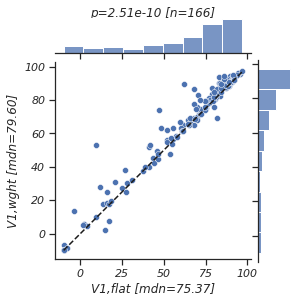

In [1261]:
#########
# ADJUST
#########
use_cv = True;
clr_by_expt = False;
abbrv_lims = False
incl_info = True

# whichMetr = 'NLL';
whichMetr = 'vExp';
nll_spec = 2; # 0/1/2 [full NLL, train, test]
#########
# END ADJUST
#########

spec_str = ''
if whichMetr=='NLL':
    if use_cv and nll_spec==0:
        use_cv=False
if whichMetr=='NLL' and nll_spec!=0:
    spec_str = 'tr' if nll_spec == 1 else 'te';
    whichMetr = '%s%s' % (whichMetr, spec_str)
nll_ind = 2; # percInd is good --> perc. impr. of NLL wrt flat V1 model

curr_dir = '02_03a_%s%s/' % (whichMetr, 'CV' if use_cv else '')
saveName = '01_scatter_%s_%s%s%s.pdf' % (strs_curr[0].replace(',',''), strs_curr[1].replace(',',''), 
                                                    '_abbrv' if abbrv_lims else '', '_wInfo' if incl_info else '')

cv_str = ' (C-V)' if use_cv else ''
clip_low = -10 if whichMetr=='vExp' else -50;

# jointPlots are always esquare, so let's set the height equal to the minimum of hf.set_size
tex_height = np.min(hf.set_size(tex_width))

if whichMetr == 'vExp':
    varExpl_curr = varExpl_CV if use_cv else varExpl
    curr_metr = np.clip(varExpl_curr, clip_low, None);
elif 'NLL' in whichMetr:
    if not use_cv:
        curr_metr = all_NLLs
    else:
        curr_metr = all_NLLs_tr if nll_spec==1 else all_NLLs_te;
    curr_metr = curr_metr[:,:,nll_ind]
    curr_metr = np.clip(curr_metr, clip_low, -clip_low);
    
expNames = np.array([modsAll[x]['metadata']['fullPath'].split('/')[-3] for x in modsAll.keys()]);
exp_colors = [exp_clr(x) for x in expNames];

if clr_by_expt:
    ax = sns.jointplot(*np.transpose(curr_metr[:,inds_curr]), height=tex_height)#, kind='reg')#, scatter=False)
    exp_colors = [exp_clr(x) for x in expNames];
    ax.ax_joint.scatter(*np.transpose(curr_metr[:,inds_curr]), color=exp_colors)
else:
    ax = sns.jointplot(*np.transpose(curr_metr[:,inds_curr]), height=tex_height, kind='scatter')

if 'NLL' in whichMetr: # don't keep the distrs/marginals --> looks bad with NLL
    ax.ax_marg_x.remove()
    ax.ax_marg_y.remove()
    
rng = [np.minimum(np.nanmin(curr_metr[:,inds_curr[0]]), np.nanmin(curr_metr[:,inds_curr[1]])),
       np.maximum(np.nanmax(curr_metr[:,inds_curr[0]]), np.nanmax(curr_metr[:,inds_curr[1]]))]

for i,(lbl,ind) in enumerate(zip(strs_curr,inds_curr)):
    if i==0:
        ax.ax_joint.set_xlabel('%s [mdn=%.2f]' % (lbl, np.nanmedian(curr_metr[:,ind])));
    elif i==1:
        ax.ax_joint.set_ylabel('%s [mdn=%.2f]' % (lbl, np.nanmedian(curr_metr[:,ind])));

ax.ax_joint.axis('scaled');
ax.ax_joint.plot(rng,rng,color='k',linestyle='--');
if incl_info:
    ooh = ss.ttest_rel(*np.transpose(curr_metr[:,inds_curr]))
    ax.ax_joint.set_title('p=%.2e [n=%d]' % (ooh.pvalue, curr_metr.shape[0]), y=1.2);

# now save
if abbrv_lims and whichMetr=='vExp':
    ax.ax_joint.set_xlim([50, 100])
    ax.ax_joint.set_ylim([50, 100])
f = ax.fig
save_loc_curr = save_loc + curr_dir
if not os.path.exists(save_loc_curr):
    os.makedirs(save_loc_curr)
pdfSv = pltSave.PdfPages(save_loc_curr + saveName);
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close();

KEEP EDITING PLOTS TO ALLOW FOR NLLS OR VAREXPL (rather than dupl. plots)

This plot is unlikely to appear in the main text; instead, we can use the values saved in the plot 

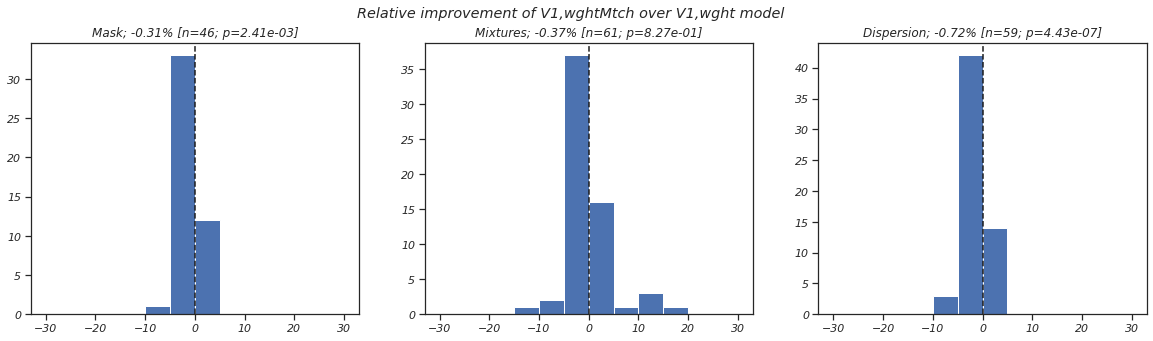

In [1141]:
dfz = np.diff(curr_metr[:,inds_curr]).flatten()

f, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True);
unq = np.unique(exp_colors, axis=0)
for iii,clr_curr in enumerate(unq):
    curr_inds = [np.all(x) for x in np.isin(exp_colors, clr_curr)]
    ax[iii].hist(dfz[curr_inds], bins=np.linspace(-30, 30, 13))
    ax[iii].axvline(0, color='k', linestyle='--')
    ooh = ss.ttest_1samp(dfz[curr_inds], popmean=0)
    ax[iii].set_title('%s; %.2f%% [n=%d; p=%.2e]' % (exp_clr(clr_curr, invert=True), 
                                                     np.nanmedian(dfz[curr_inds]), np.sum(curr_inds),
                                                    ooh.pvalue));

f.suptitle('Relative improvement of %s over %s model' % (strs_curr[1], strs_curr[0], ))
    
saveName = '02_relImprHist_%s_%s%s.pdf' % (strs_curr[0].replace(',',''), strs_curr[1].replace(',',''), '_abbrv' if abbrv_lims else '')

if not os.path.exists(save_loc_curr):
    os.makedirs(save_loc_curr)
pdfSv = pltSave.PdfPages(save_loc_curr + saveName);
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close();

Use these cells to get specific cells which have large discrepancies between the two models:

In [1142]:
diffz = np.diff(varExpl_curr[:, inds_curr]).flatten()
odds = np.where(np.logical_and(np.abs(diffz)<0.2, varExpl_curr[:,inds_curr[0]]>85))[0]
print(odds)

[  2   3   6  16  20  43  44  46  57  63  78 137]


In [1143]:
[print('  %s/%d: \t[%.2f, %.2f]' % (expNames[currInd],
                     modsAll[currInd]['metadata']['cellNum'],
                              *curr_data[currInd,inds_curr,percInd])) for currInd in odds]

  V1_orig/3: 	[5.28, 4.17]
  V1_orig/4: 	[0.86, 0.67]
  V1_orig/7: 	[3.27, 2.87]
  V1_orig/17: 	[0.92, 1.59]
  V1_orig/21: 	[1.33, 1.07]
  V1_orig/44: 	[0.02, 0.44]
  V1_orig/45: 	[0.30, 0.43]
  V1_orig/47: 	[0.63, 0.62]
  V1_orig/58: 	[1.80, 0.21]
  altExp/5: 	[0.95, 2.05]
  V1/12: 	[1.18, 0.59]
  V1_BB/19: 	[0.28, 0.27]


[None, None, None, None, None, None, None, None, None, None, None, None]

Now, we'll convert varExpl into color!

In [1144]:
sqrt_trans = lambda x: np.sign(x)*np.sqrt(np.abs(x))

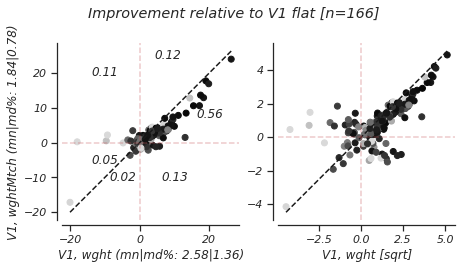

In [1145]:
if whichMetr=='NLLte': # this is fixed plot --> we'll only make this with NLLte

    curr_dir = '02_03a_%s%s/' % (whichMetr, 'CV')

    which_data = 2 # 0/1/2 (non-CV/train/test)
    dataStr = '_cvTest' if which_data==2 else '_cvTrain' if which_data==1 else '';

    curr_data = dataOrg[which_data];
    varExpl_curr = varExpl_CV if which_data>0 else varExpl

    saveName = '03_percNLL_scatter%s_%s_%s.pdf' % (dataStr, strs_curr[0].replace(',',''), strs_curr[1].replace(',',''))

    nrow, ncol = 1, 2; # once as normal, once as sqrt of improvement

    f, ax = plt.subplots(nrow,ncol,figsize=hf.set_size(tex_width));

    # low_clip = None # prct
    low_clip = -20 # prct

    # temporarily to avoid bad scales, make the minimum no smaller than low_clip
    mn = np.maximum(low_clip, np.minimum(*np.nanmin(curr_data[:,inds_curr,percInd],axis=0)))
    mx = np.maximum(low_clip, np.maximum(*np.nanmax(curr_data[:,inds_curr,percInd],axis=0)))

    mdns = np.nanmedian(curr_data[:,inds_curr,percInd], axis=0)
    means = np.nanmean(curr_data[:,inds_curr,percInd], axis=0)

    clrs = cm.gray_r(np.linspace(0.15, 1, 100)) # why 100? cap varExpl at 0 --> goes up to 100
    vExp_clip_int = np.round(np.clip(varExpl_curr, 0, None)).astype('int8');

    lgnStrs = []; normStrs = [];
    for modN in inds_curr:
        lVal, nVal = modsAll[akey]['model']['inputsSpecified']['lgnFrontEnd'][modN], modsAll[akey]['model']['inputsSpecified']['normType'][modN]
        lgnStr = hf.lgnType_suffix(lVal).replace('_','');
        lgnStr = 'V1' if lgnStr=='' else lgnStr;
        normModStr = hf.fitType_suffix(nVal).replace('_','')
        lgnStrs.append(lgnStr);
        normStrs.append(normModStr)

    for curr_plt in range(ncol):

        sqrt_str = ' [sqrt]' if curr_plt==1 else ''
        dtls_str_x = ' (mn|md%%: %.2f|%.2f)' % (means[0], mdns[0])
        dtls_str_y = ' (mn|md%%: %.2f|%.2f)' % (means[1], mdns[1])

        ax[curr_plt].set_xlabel('%s, %s%s%s' % (lgnStrs[0], normStrs[0], sqrt_str, dtls_str_x if curr_plt==0 else ''))
        if curr_plt==0:
            # only make y label on first plot of row
            ax[curr_plt].set_ylabel('%s, %s%s%s' % (lgnStrs[1], normStrs[1], sqrt_str, dtls_str_y if curr_plt==0 else ''))
            ax[curr_plt].plot([mn,mx], [mn,mx], 'k--');
            ax[curr_plt].scatter(*np.transpose(np.clip(curr_data[:,inds_curr,percInd], low_clip, None)),
                                color=clrs[np.nanmean(vExp_clip_int[:,inds_curr], axis=1).astype('int')]);
        elif curr_plt==1: # sqrt!
            ax[curr_plt].plot(sqrt_trans([mn,mx]), sqrt_trans([mn,mx]), 'k--');
            ax[curr_plt].scatter(*np.transpose(sqrt_trans(np.clip(curr_data[:,inds_curr,percInd], low_clip, None))),
                                color=clrs[np.nanmean(vExp_clip_int[:,inds_curr], axis=1).astype('int')]);

        ax[curr_plt].axis('scaled')
        # and zero lines
        ax[curr_plt].axhline(0, color='r', linestyle='--', alpha=0.3)
        ax[curr_plt].axvline(0, color='r', linestyle='--', alpha=0.3)

    #     for jj, axis in enumerate([ax[row_ind, col_ind].xaxis, ax[row_ind, col_ind].yaxis]):
    #         axis.set_major_formatter(FuncFormatter(lambda x,y: '%d' % x if x>=1 else '%.1f' % x)) # this will make everything in non-scientific notation!
    #         if jj==1: # i.e. y axis, make sure we have tick labels, here, too
    #             axis.set_tick_params(labelleft=True); 

    ### what perc. in each (sub) quadr?
    nCells = len(curr_data[:,inds_curr,percInd])
    a_gt_b = np.diff(curr_data[:,inds_curr,percInd]).flatten()<0 # diff does [i+1]-[i]
    b_gt_a = np.diff(curr_data[:,inds_curr,percInd]).flatten()>0
    both_gt0 = np.logical_and(*np.transpose(curr_data[:,inds_curr,percInd]>0))
    both_lt0 = np.logical_and(*np.transpose(curr_data[:,inds_curr,percInd]<0))
    # in q1, below and then above diagonal
    ax[0].text(20, 8, '%.2f' % (np.sum(both_gt0 & a_gt_b)/nCells), horizontalalignment='center', verticalalignment='center')
    ax[0].text(8, 25, '%.2f' % (np.sum(both_gt0 & b_gt_a)/nCells), horizontalalignment='center', verticalalignment='center')
    # in q3, below and then above diagonal
    ax[0].text(-5, -10, '%.2f' % (np.sum(both_lt0 & a_gt_b)/nCells), horizontalalignment='center', verticalalignment='center')
    ax[0].text(-10, -5, '%.2f' % (np.sum(both_lt0 & b_gt_a)/nCells), horizontalalignment='center', verticalalignment='center')
    # i.e. x-axis neg, y-axis pos
    quadr_2 = np.logical_and(curr_data[:,inds_curr[0],percInd]<0, curr_data[:,inds_curr[1],percInd]>0)
    ax[0].text(-10, 20, '%.2f' % (np.sum(quadr_2)/nCells), horizontalalignment='center', verticalalignment='center')
    # i.e. x-axis pos, y-axis neg
    quadr_4 = np.logical_and(curr_data[:,inds_curr[0],percInd]>0, curr_data[:,inds_curr[1],percInd]<0)
    ax[0].text(10, -10, '%.2f' % (np.sum(quadr_4)/nCells), horizontalalignment='center', verticalalignment='center')


    f.suptitle('Improvement relative to V1 flat [n=%d]' % (nCells), y=0.90);
    f.tight_layout();
    sns.despine(offset=5);

    # now save
    save_loc_curr = save_loc + curr_dir
    if not os.path.exists(save_loc_curr):
        os.makedirs(save_loc_curr)
    pdfSv = pltSave.PdfPages(save_loc_curr + saveName);
    pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
    pdfSv.close()


    # print which are farthest away from diagonal?
    abs_order = True
    howMany = 5;
    strt = 0
    # ----
    diffs = np.diff(curr_data[:,inds_curr,percInd]).flatten()
    # Here, negative values mean the second model has a higher improvement over the flat model, as compared to first model
    if abs_order:
        asort = np.argsort(-np.abs(diffs))
    else:
        asort = np.argsort(diffs)
    whichOnes = np.arange(strt,strt+howMany)

In [1146]:
print('Farthest off diagonal:')
[print('  %s/%d: \t[%.2f, %.2f]' % (expNames[currInd],
                     modsAll[currInd]['metadata']['cellNum'],
                              *curr_data[currInd,inds_curr,percInd])) for currInd in asort[whichOnes]]

Farthest off diagonal:
  V1/11: 	[-17.94, 0.20]
  V1/39: 	[-28.87, -17.15]
  V1/17: 	[13.02, 1.46]
  V1/43: 	[-9.26, 2.17]
  V1/35: 	[-9.60, 0.49]


[None, None, None, None, None]

# 3. Looking for example cells

In [1377]:
v1_pd[v1_pd['ref_mod_vExp']>85][['expDir', 'cellNum', 'maxResp', 'meanResp', 'respMeasure', 
                                 'ref_mod_vExp', 'wt_mod_vExp', 
                                 'ref_mod_NLL_te', 'wt_mod_NLL_te',]]
#                                  'best_mod_vExp', 'sfVarExpl_hiCon']]

,expDir,cellNum,maxResp,meanResp,respMeasure,ref_mod_vExp,wt_mod_vExp,ref_mod_NLL_te,wt_mod_NLL_te
2,V1_orig,3,50.800,22.193,0,86.776,88.300,1.578,1.495
3,V1_orig,4,102.500,23.133,0,95.578,95.851,1.050,1.041
5,V1_orig,6,64.300,18.335,0,89.581,93.804,1.826,1.703
6,V1_orig,7,43.200,12.979,0,90.186,91.852,1.531,1.481
9,V1_orig,10,50.900,13.272,0,90.774,94.331,1.135,1.010
12,V1_orig,13,22.800,6.135,0,90.898,91.251,0.910,0.906
16,V1_orig,17,45.100,20.405,0,88.138,89.564,1.463,1.450
19,V1_orig,20,157.100,70.939,0,89.651,94.655,2.042,1.727
20,V1_orig,21,82.900,33.095,0,87.260,88.236,1.703,1.681
25,V1_orig,26,135.429,42.187,0,88.162,90.465,3.039,2.927


In [1383]:
autoreload.reload(psf); autoreload.reload(hf);

In [1339]:
#### directory for these fits
curr_dir = '03_ex_fits_noLGN/'

##### Use the below cells for altExp/ and V1/, respectively; V1_BB/ should be handled in plot_sfBB_vertical.py, still

*Use this plot for altExp/*

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5409: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  spike_times = np.array([trial_inf['spikeTimes'][x] for x in all_trs]);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5409: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1229: VisibleDepr

oh


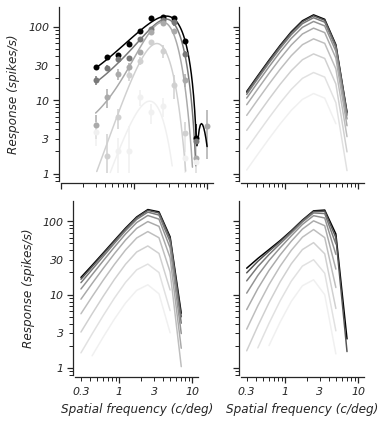

In [1341]:
common_axes = True
f,yax=plt.subplots(2,2, figsize=hf.set_size(tex_width, extra_height=1.5), sharex=common_axes, sharey=common_axes)

expDir = 'altExp/'
cellNum = 4;

full=False; # show legend/titles? Should run once to have info for legend
forceLog = True
incl_data = False

cns_data = [0,2] # cons data
cns_mod = cns_data if incl_data else [0,1] # incl. all!

# less likely to change...
joint = 10;
use_tex = False
date = '220811vEs';
# date = '220807vEs';
# --- other dates
phDate = '220718';
rvcDate = '220718'
rvcDate_altExp = '220609';


if full:
    incl_legend=False
    subplot_title=True
else:
    incl_legend=False
    subplot_title=False

saveName = '%s_%02d%s%s%s.pdf' % (expDir.replace('/',''), cellNum, '_full' if full else '', 
                                  '_log' if forceLog else '_lin', '_noDt' if not incl_data else '')
    
# and with model
ae_flat = hf.np_smart_load('%sstructures/fitListHPC_pyt_nr230118a_noRE_noSched_dG_flat_sqrt.npy' % expDir);
psf.plot_sfs(yax, 0, 1, cellNum, expDir, descrBase='descrFitsHPC_%s' % date, subset_cons=cns_mod, descrMod=3, joint=joint, rvcAdj=0, forceLog=forceLog,
             rvcBase='rvcFitsHPC_%s' % rvcDate_altExp, incl_legend=incl_legend, subplot_title=subplot_title, 
             use_tex=use_tex, mod_fits=ae_flat, normType=1, lgnFrontEnd=0, incl_data=incl_data)

ae_wght = hf.np_smart_load('%sstructures/fitListHPC_pyt_nr230118a_noRE_noSched_dG_DGwght_sqrt.npy' % expDir);
psf.plot_sfs(yax, 1, 1, cellNum, expDir, descrBase='descrFitsHPC_%s' % date, subset_cons=cns_mod, descrMod=3, joint=joint, rvcAdj=0, forceLog=forceLog,
             rvcBase='rvcFitsHPC_%s' % rvcDate_altExp, incl_legend=incl_legend, subplot_title=subplot_title, 
             use_tex=use_tex, mod_fits=ae_wght, normType=2, lgnFrontEnd=0, incl_data=incl_data)

ae_wght_match = hf.np_smart_load('%sstructures/fitListHPC_pyt_nr230118a_noRE_noSched_dG_DGwghtMtch_sqrt.npy' % expDir);
psf.plot_sfs(yax, 1, 0, cellNum, expDir, descrBase='descrFitsHPC_%s' % date, subset_cons=cns_mod, descrMod=3, joint=joint, rvcAdj=0, forceLog=forceLog,
             rvcBase='rvcFitsHPC_%s' % rvcDate_altExp, incl_legend=incl_legend, subplot_title=subplot_title, 
             use_tex=use_tex, mod_fits=ae_wght_match, normType=7, lgnFrontEnd=0, incl_data=incl_data)

    
# DATA
psf.plot_sfs(yax, 0, 0, cellNum, expDir, descrBase='descrFitsHPC_%s' % date, subset_cons=cns_data, descrMod=3, forceLog=forceLog, 
             joint=joint, rvcAdj=0, rvcBase='rvcFitsHPC_%s' % rvcDate_altExp, incl_legend=incl_legend, subplot_title=subplot_title, use_tex=use_tex)


if incl_legend or subplot_title:
    if forceLog:
        f.tight_layout(w_pad=-6);
else:
    print('oh')
    if forceLog:
        f.tight_layout(w_pad=-3, h_pad=1);
#     f.subplots_adjust(wspace=-0.025)

# now save
save_loc_curr = save_loc + curr_dir
if not os.path.exists(save_loc_curr):
    os.makedirs(save_loc_curr)
pdfSv = pltSave.PdfPages(save_loc_curr + saveName);
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()

*And this plot for V1/*

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5409: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  spike_times = np.array([trial_inf['spikeTimes'][x] for x in all_trs]);
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:862: RuntimeWarning: invalid value encountered in double_scalars
  th = [np.rad2deg(np.arctan(np.abs(y_coord[i]/x_coord[i]))) for i in range(len(x_coord))];


phaseAdvanceFitsHPC_230111


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5409: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  spike_times = np.array([trial_inf['spikeTimes'][x] for x in all_trs]);
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:862: RuntimeWarning: invalid value encountered in double_scalars
  th = [np.rad2deg(np.arctan(np.abs(y_coord[i]/x_coord[i]))) for i in range(len(x_coord))];


phaseAdvanceFitsHPC_230111


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5409: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  spike_times = np.array([trial_inf['spikeTimes'][x] for x in all_trs]);
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:862: RuntimeWarning: invalid value encountered in double_scalars
  th = [np.rad2deg(np.arctan(np.abs(y_coord[i]/x_coord[i]))) for i in range(len(x_coord))];


phaseAdvanceFitsHPC_230111


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5409: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  spike_times = np.array([trial_inf['spikeTimes'][x] for x in all_trs]);
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:862: RuntimeWarning: invalid value encountered in double_scalars
  th = [np.rad2deg(np.arctan(np.abs(y_coord[i]/x_coord[i]))) for i in range(len(x_coord))];


phaseAdvanceFitsHPC_230111


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


not adjusting


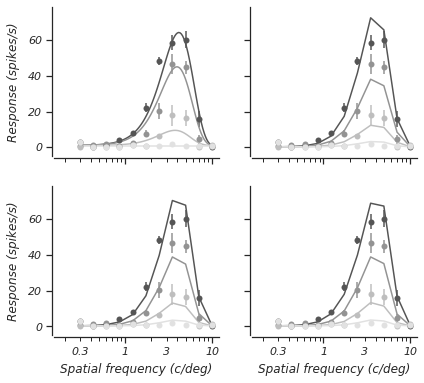

In [1389]:
common_axes = True
f,yax=plt.subplots(2,2, figsize=hf.set_size(tex_width, extra_height=1.5), sharex=common_axes, sharey=common_axes)

cellNum = 51
expDir = 'V1/'
incl_data = True

cns_data = [1,2] # cons data
cns_mod = cns_data if incl_data else [0,1] # incl. all!

full     = False; # show legend/titles? Should run once to have info for legend
forceLog = False

# less likely to change
joint = 10;
date = '230111vEs';
use_tex = True
# --- dates
phDate = '230111';
rvcDate = '230111'

if full:
    incl_legend=False
    subplot_title=True
else:
    incl_legend=False
    subplot_title=False
    
saveName = '%s_%02d%s%s%s.pdf' % (expDir.replace('/',''), cellNum, '_full' if full else '', 
                                  '_log' if forceLog else '_lin', '_noDt' if not incl_data else '')

# and with models
ae_flat = hf.np_smart_load('%sstructures/fitListHPC_pyt_nr230118a_noRE_noSched_dG_flat_sqrt.npy' % expDir);
psf.plot_sfs(yax, 0, 1, cellNum, expDir, descrBase='descrFitsHPC_%s' % date, subset_cons=cns_mod, descrMod=3, joint=joint, rvcAdj=1, forceLog=forceLog,
             rvcBase='rvcFitsHPC_%s' % rvcDate, phBase='phaseAdvanceFitsHPC_%s' % phDate, incl_legend=incl_legend, subplot_title=subplot_title, 
             use_tex=use_tex, mod_fits=ae_flat, normType=1, lgnFrontEnd=0, incl_data=incl_data)

ae_wght = hf.np_smart_load('%sstructures/fitListHPC_pyt_nr230118a_noRE_noSched_dG_DGwght_sqrt.npy' % expDir);
psf.plot_sfs(yax, 1, 1, cellNum, expDir, descrBase='descrFitsHPC_%s' % date, subset_cons=cns_mod, descrMod=3, joint=joint, rvcAdj=1, forceLog=forceLog,
             rvcBase='rvcFitsHPC_%s' % rvcDate, phBase='phaseAdvanceFitsHPC_%s' % phDate, incl_legend=incl_legend, subplot_title=subplot_title, 
             use_tex=use_tex, mod_fits=ae_wght, normType=2, lgnFrontEnd=0, incl_data=incl_data)

ae_wght_match = hf.np_smart_load('%sstructures/fitListHPC_pyt_nr230118a_noRE_noSched_dG_DGwghtMtch_sqrt.npy' % expDir);
psf.plot_sfs(yax, 1, 0, cellNum, expDir, descrBase='descrFitsHPC_%s' % date, subset_cons=cns_mod, descrMod=3, joint=joint, rvcAdj=1, forceLog=forceLog,
             rvcBase='rvcFitsHPC_%s' % rvcDate, phBase='phaseAdvanceFitsHPC_%s' % phDate, incl_legend=incl_legend, subplot_title=subplot_title, 
             use_tex=use_tex, mod_fits=ae_wght_match, normType=7, lgnFrontEnd=0, incl_data=incl_data)

    
# DATA
psf.plot_sfs(yax, 0, 0, cellNum, expDir, descrBase='descrFitsHPC_%s' % date, subset_cons=cns_data, forceLog=forceLog,
             descrMod=3, joint=joint, rvcAdj=1, rvcBase='rvcFitsHPC_%s' % rvcDate, phBase='phaseAdvanceFitsHPC_%s' % phDate, 
             incl_legend=incl_legend, subplot_title=subplot_title, use_tex=use_tex)


if incl_legend or subplot_title:
    if forceLog:
        f.tight_layout(w_pad=-6);
else:
    print('not adjusting')
    if forceLog:
        f.tight_layout(w_pad=-3, h_pad=1);
    # this one was mostly unused
#     f.subplots_adjust(wspace=-0.025)

# now save
save_loc_curr = save_loc + curr_dir
if not os.path.exists(save_loc_curr):
    os.makedirs(save_loc_curr)
pdfSv = pltSave.PdfPages(save_loc_curr + saveName);
pdfSv.savefig(f, bbox_inches='tight') # only one figure here...
pdfSv.close()